![title](img/Portada.jpg)

# Trabajo Práctico 1: Análisis Exploratorio - Cuidado! Lluvia de Hamburgesas

### Alumnos y padrón:
* Primerano Lomba, Franco Alejandro 106004
* Montecalvo, Ignacio 105555

## Introducción
En dicho trabajo se realizará un análisis de datos ofrecidos por Flint Lockwood, el cual registró a lo largo de varios dias las condiciones climáticas de ese dia en cuestión, la fecha y barrio en que se hizo el registro.

Con estos datos, se propone buscar un patrón en el comportamiento de la máquina que hace llover hamburguesas en base a dichas condiciones climáticas e intentar predecir si al siguiente día lloverá o no hamburguesas.

## Objetivos

* Limpiar y preparar los datos para su posterior análisis.
* Analizar e interpretar los datos buscando relaciones entre los mismos.
* Buscar un patrón en el comportamiento de la máquina de llover hamburguesas mediante el planteo de una serie de interrogantes.
* Construir un baseline para predecir con cierta precisión si lloverá hamburguesas el día siguiente.


## Configuraciones Iniciales

En primer lugar importaremos las bibliotecas que se utilizarán a lo largo del trabajo

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

## Carga y limpieza del set de datos
Cargamos ambos datasets y realizamos un merge entre ellos.

In [95]:
dataset = pd.read_csv('Datasets/features.csv')
dataset.head()

/home/nacho/Escritorio/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,...,presion_atmosferica_tarde,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano
0,Retiro,2016-10-11,Este,Nornoreste,10.7,59.0,56.0,86942,no,16.0,...,1009.9,1010.2,Estesureste,33.0,29.2,16.8,24.1,25.3,19.0,4.0
1,Vélez Sársfield,2016-03-28,Sur,suroeste,0.0,49.0,83.0,102098,no,2.6,...,1020.4,1021.4,Sur,31.0,16.9,10.6,16.4,12.3,13.0,7.0
2,Palermo,2017-05-11,Sursureste,Norte,4.3,59.0,83.0,67154,no,2.4,...,1024.8,1026.5,Norte,26.0,16.6,4.4,15.7,9.4,9.0,13.0
3,Mataderos,2012-05-07,suroeste,Sur,NaN,67.0,93.0,50245,no,NaN,...,1017.0,1020.0,Oestesuroeste,13.0,11.4,0.8,11.1,4.0,6.0,6.0
4,Recoleta,2014-06-19,Nornoreste,Nornoreste,0.8,94.0,97.0,82904,no,0.8,...,1016.1,1021.9,Nornoreste,33.0,11.6,6.7,11.2,8.8,11.0,15.0


In [96]:
dataset_target = pd.read_csv('Datasets/target.csv')
dataset_target.head()

,id,llovieron_hamburguesas_al_dia_siguiente
0,86942,no
1,102098,no
2,67154,no
3,50245,no
4,82904,no


En primer lugar, comenzamos haciendo un merge entre el dataset con los registros climáticos y el dataset con la variable target según la id de cada registro. Como el feature 'id' sólo nos será útil para realizar dicho merge pero no para llevar a cabo el análisis del comportamiento de las features en relación con la variable target, decidimos descartar dicha columna.

In [97]:
dataset = pd.merge(dataset, dataset_target, how='left', left_on='id', right_on='id')
dataset.drop('id', inplace=True, axis=1)

Ahora, podemos observar que existen varias filas de las cuales desconocemos la variable target:

In [98]:
dataset_target.isnull().sum().to_frame().rename(columns={0:'valores NaN'})

,valores NaN
id,0
llovieron_hamburguesas_al_dia_siguiente,2639


Como vemos que hay 2639 filas de las cuales se desconoce si al dia siguiente llovieron hamburguesas o no.
Como buscamos predecir aquellos dias cuyo dia siguiente se produjo una lluvia de hamburguesas, descartaremos aquellas filas que no contengan dicha información ya que el resto de los datos de cada una de esas filas los consideramos de nula importancia. Podríamos hacerlo más adelante, cuando nos tengamos que centrar en el target, pero al ser 2639 filas solo una pequeña parte del total de filas que tenemos (116368), decidimos descartarlas en este momento.

In [99]:
dataset = dataset[(dataset.llovieron_hamburguesas_al_dia_siguiente == 'si') | (dataset.llovieron_hamburguesas_al_dia_siguiente == 'no')]

---

Luego, notamos que al importar el dataset aparece una advertencia de que la columna 13 (presion_atmosferica_tarde) contiene "datos de tipos mezclados". Nos propusimos analizar que significaba esto.

In [100]:
dataset.presion_atmosferica_tarde.unique()

array(['1009.9', '1020.4', '1024.8', ..., 980.2, 1037.8, 985.4],
      dtype=object)

Aquí notamos que hay valores de tipo string y valores numéricos, así que intentamos convertirlos todos a numericos. Pero al intentar convertir todos los datos a float64 nos topamos con un inconveniente, existen numeros que no son válidos. Al parecer, hay valores con más de un punto. Son particularmente dos: 10.167.769.999.999.900 y 1.009.555  
Considerando el resto de los valores, creemos que se produjo un error en la carga de datos, y siendo solo 2 los afectados, decidimos descartarlos.

In [101]:
dataset = dataset[dataset.presion_atmosferica_tarde != '10.167.769.999.999.900']
dataset = dataset[dataset.presion_atmosferica_tarde != '1.009.555']
dataset.presion_atmosferica_tarde = dataset.presion_atmosferica_tarde.astype(np.float64)

Por otro lado, creemos que si la lluvia de hamburguesas está relacionada a los mismos factores que lal lluvia normal nos puede servir construirnos un feature nuevo a partir de las fechas el cual consista en la estación del año en que se tomó el registro.

In [102]:
# Función que determina si una fecha pertenece a la estación que se indica mediante el mes_inicio y mes_fin
def es_estacion(fechas, mes_inicio, mes_fin):
    if(mes_fin == 0):
        mes_fin = 12
        
    return (((mes_inicio%12 +1) <= fechas.month < mes_fin) or 
            (fechas.month == mes_fin and fechas.day < 21)   or 
            (fechas.month == mes_inicio and fechas.day >= 21))

In [103]:
#Convertimos fechas a Data Time
dataset['dia'] = pd.to_datetime(dataset['dia'], errors='coerce')
estaciones = []

#Obtenemos las mascaras booleanas segun la estación a la que corresponden
for i in range(3,13,3):
    estaciones.append(dataset.dia.apply(es_estacion, args=(i, (i+3)%12)))

#Creamos nueva columna y llenamos los valores
serie_estaciones = pd.Series(data= estaciones, index=['Otonio','Invierno','Primavera','Verano'])
for j in range(0,4):
    dataset.loc[serie_estaciones[j],'estacion'] = serie_estaciones.index[j]

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113727 entries, 0 to 116367
Data columns (total 24 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   barrio                                   113727 non-null  object        
 1   dia                                      113727 non-null  datetime64[ns]
 2   direccion_viento_tarde                   110723 non-null  object        
 3   direccion_viento_temprano                105764 non-null  object        
 4   horas_de_sol                             59511 non-null   float64       
 5   humedad_tarde                            110854 non-null  float64       
 6   humedad_temprano                         112314 non-null  float64       
 7   llovieron_hamburguesas_hoy               112602 non-null  object        
 8   mm_evaporados_agua                       65095 non-null   float64       
 9   mm_lluvia_dia             

## Missing values

In [9]:
columnas_numericas = dataset.select_dtypes(include=['float64']).columns
porcentaje_missings= []

for c in columnas_numericas:
    porcentaje_missings.append(round(dataset[c].isnull().mean()*100,2))

pd.Series(data=porcentaje_missings, index=columnas_numericas).sort_values(ascending=False).to_frame('Porcentaje de Missing Values (%)')

,Porcentaje de Missing Values (%)
horas_de_sol,47.67
mm_evaporados_agua,42.76
nubosidad_tarde,40.12
nubosidad_temprano,37.69
presion_atmosferica_temprano,9.83
presion_atmosferica_tarde,9.81
rafaga_viento_max_velocidad,6.52
humedad_tarde,2.53
temperatura_tarde,1.92
velocidad_viendo_tarde,1.84


Ahora vamos a analizar los valores que tenemos en las columnas numéricas.

Para empezar, vemos que destacan cuatro columnas que poseen una gran cantidad de 'NaN'. Estas son:
* horas_de_sol       -> 47.67%
* mm_evaporados_agua -> 42.76%
* nubosidad_tarde    -> 40.12%
* nubosidad_temprano -> 37.69%  
  
Por lo que debemos prestar especial atencion al trabajar con estos features 

### ¿Existe alguna relación entre: horas de sol, nubosidad tarde y nubosidad temprano?

Para buscar alguna relación entre estas features centrándonos en los missing values, primero vamos a identificar a los mismos con un -1

In [10]:
dataset.horas_de_sol.fillna(value=-1, inplace=True)
dataset.nubosidad_temprano.fillna(value=-1, inplace=True)
dataset.nubosidad_tarde.fillna(value=-1, inplace=True)

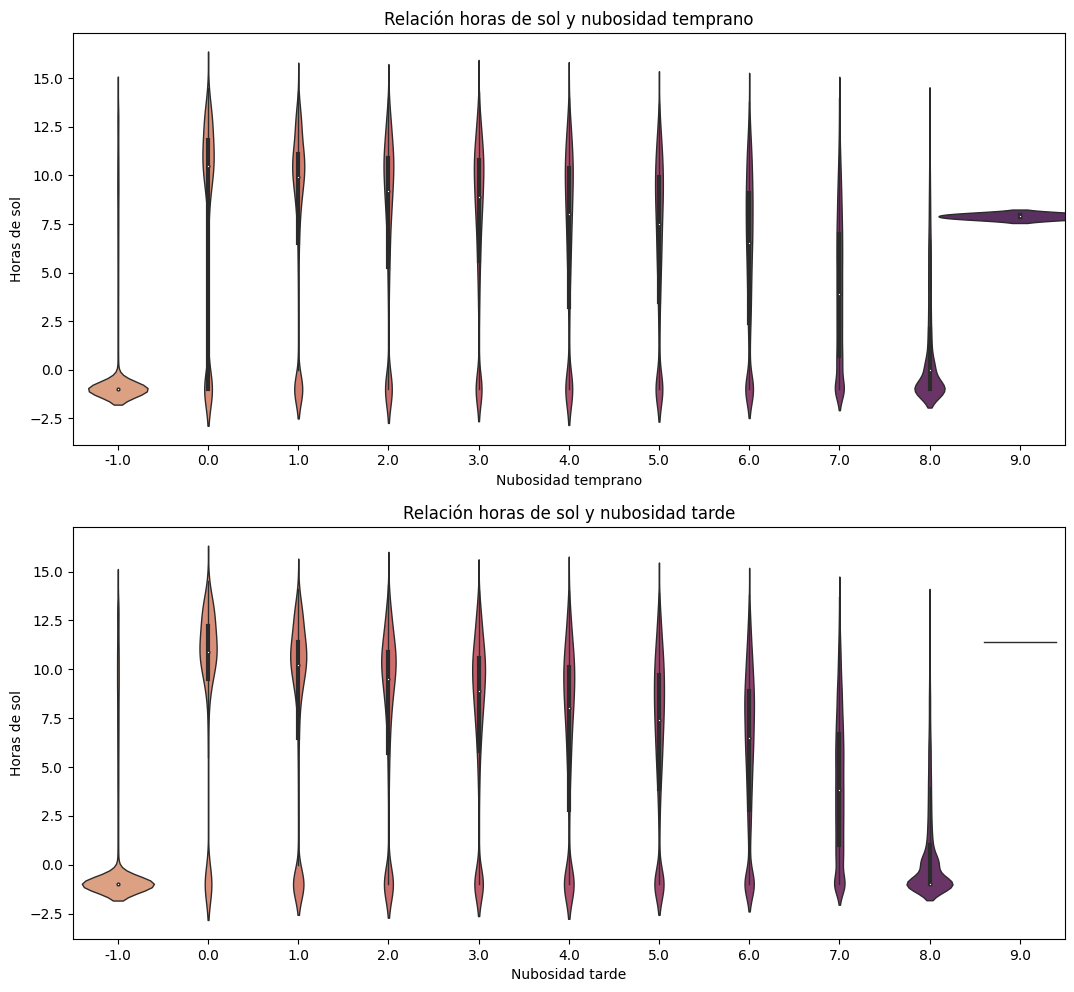

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[6.4*2, 12], dpi=100)

axes[0].set_title("Relación horas de sol y nubosidad temprano")
sns.violinplot(
    data=dataset[['horas_de_sol','nubosidad_temprano']],
    y='horas_de_sol',
    x='nubosidad_temprano',
    linewidth=1,
    width=1.8,
    palette='flare',
    ax=axes[0])
axes[0].set_ylabel("Horas de sol")
axes[0].set_xlabel("Nubosidad temprano")


axes[1].set_title("Relación horas de sol y nubosidad tarde")
sns.violinplot(
    data=dataset[['horas_de_sol','nubosidad_tarde']],
    y='horas_de_sol',
    x='nubosidad_tarde',
    linewidth=1,
    palette='flare',
    ax=axes[1])
axes[1].set_ylabel("Horas de sol")
axes[1].set_xlabel("Nubosidad tarde")

plt.show()

Se puede observar que a grandes rasgos se mantiene una relación esperada: cuanto mayor es la nubosidad entonces menor cantidad de horas de sol hay. Si bien existen excepciones, mirando los Violin Plot vemos que la parte de mayor densidad cumple con este comportamiento. Además, se puede ver que en la mayoria de los casos que se desconoce la nubosidad (-1) también coincide con la mayoria de los casos en que se desconoce las horas de sol (-1), por lo que concluimos que están directamente relacionados.  
Es por esto, que utilizaremos los valores de horas_de_sol, nubosidad tarde y temprano conocidos para poder reducir el porcentaje de missing values en estos tres features.  
Empezamos completando los missings en horas de sol de las instancias cuyos valores de nubosidad son conocidos. Para ello buscamos el promedio de hs de sol que poseen las instancias que comparten el mismo nivel de nubosidad.  Además, eliminamos las tres instancias que tienen nubosidad 9 debido a que es muy probable que sean ruido debido a que no encaja con sus valores de horas de sol.

In [11]:
nubosidad_nueve = (dataset.nubosidad_temprano == 9) | (dataset.nubosidad_tarde == 9)
dataset[nubosidad_nueve][['dia','nubosidad_temprano','nubosidad_tarde']]

,dia,nubosidad_temprano,nubosidad_tarde
76958,2012-11-02,6.0,9.0
85612,2012-05-27,9.0,-1.0
114692,2009-09-23,9.0,3.0


In [12]:
#Eliminamos filas con nubosidad 9
dataset = dataset[(dataset.nubosidad_temprano != 9)&(dataset.nubosidad_tarde != 9)]

#Obtenemos horas de sol a partir de niveles de nubosidad

for i in np.sort(dataset.nubosidad_tarde.unique())[1:]:
    nubosidad_i = (dataset.nubosidad_tarde == i)
    promedio_hs_de_sol = dataset[ (dataset.horas_de_sol != -1) & nubosidad_i].horas_de_sol.mean()
    dataset.loc[(dataset.horas_de_sol == -1) & nubosidad_i, 'horas_de_sol'] = promedio_hs_de_sol
    
for i in np.sort(dataset.nubosidad_temprano.unique())[1:]:
    nubosidad_i = (dataset.nubosidad_temprano == i)
    promedio_hs_de_sol = dataset[ (dataset.horas_de_sol != -1) & nubosidad_i].horas_de_sol.mean()
    dataset.loc[(dataset.horas_de_sol == -1) & nubosidad_i, 'horas_de_sol'] = promedio_hs_de_sol

Ahora vemos cuál es el porcentaje de missings que quedó para horas de sol:

In [16]:
print("Porcentaje missings horas de sol:", round((dataset.horas_de_sol == -1).mean()*100,2),'%')

Porcentaje missings horas de sol: 29.69 %


Logramos reducir significativamente la cantidad de missing values del feature de Horas de sol pasando de un 47.67% a un 29.69% utilizando valores que deberían ser cercanos a los verdaderos.  
Ahora vamos a ver qué relación existe entre la nubosidad tarde y temprano. En principio creemos que en la mayoria de los casos cuanto mas marcada sea la nubosidad (muy nublado o nada nublado) hay más posibilidades de que permanezca así durante el resto del día. Veamos...

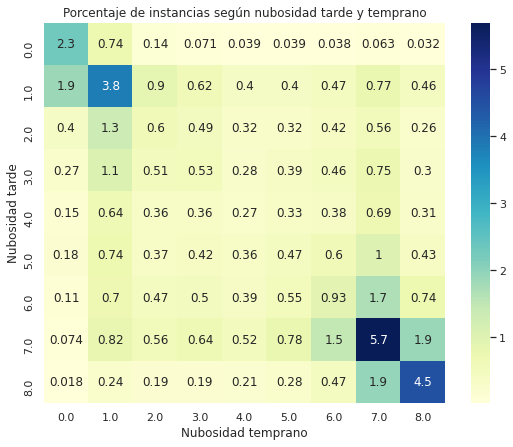

In [17]:
df_nubosidad = dataset.groupby(['nubosidad_tarde','nubosidad_temprano']).agg({'barrio':'count'})
pivot_nubosidad = pd.pivot_table(data = df_nubosidad, 
                                index = 'nubosidad_tarde', 
                                values = 'barrio', 
                                columns = 'nubosidad_temprano')
pivot_nubosidad = pivot_nubosidad.apply(lambda x: x/(len(dataset)) *100)

sns.set(rc={'figure.figsize':(9,7)})
heatmap_nubosidad = sns.heatmap(pivot_nubosidad.drop(-1,axis=1).drop(-1), cmap="YlGnBu", annot=True)
heatmap_nubosidad.set_ylabel("Nubosidad tarde")
heatmap_nubosidad.set_xlabel("Nubosidad temprano")
heatmap_nubosidad.set_title("Porcentaje de instancias según nubosidad tarde y temprano")
plt.show()

Efectivamente, se cumple lo que propusimos. En los extremos es donde hay mayor coincidencia. En los valores intermedios hay mayor variación y no hay nada muy claro. A pesar de que hay una relación, la misma no es exactamente 1 a 1, por lo que creemos que lo mas acertado para los missing values de nubosidad es:
* Para las muestras con missing en nubosidad tarde y con una nubosidad temprano con valor en los extremos (0,1,7,8), vamos a reemplazar el missing por el valor promedio de nubosidad tarde de todas las muestras que compartan su valor de nubosidad temprano (y no tengan missing en nubosidad tarde). Viceversa para los missings en nubosidad temprano.
* Para los missings restantes utilizaremos un imputer, elegimos KNNImputer, seleccionando como atributos a tener en cuenta las horas de sol y las dos nubosidades. Optamos por esta decisión ya que por un lado, para las muestras con valores intermedios de nubosidad no hay una relación clara, y por el otro, para las muestras que tienen missings en las tres features tampoco podemos rellenarlos siguiendo algún razonamiento

In [12]:
for i in [0,1,7,8]:
    promedio_nubosidad_tarde = round(dataset[(dataset.nubosidad_temprano == i) & (dataset.nubosidad_tarde != -1)].nubosidad_tarde.mean())
    promedio_nubosidad_temprano = round(dataset[(dataset.nubosidad_tarde == i) & (dataset.nubosidad_temprano != -1)].nubosidad_temprano.mean())
    dataset.loc[(dataset.nubosidad_temprano == i) & (dataset.nubosidad_tarde == -1),'nubosidad_tarde'] = promedio_nubosidad_tarde
    dataset.loc[(dataset.nubosidad_tarde == i) & (dataset.nubosidad_temprano == -1),'nubosidad_temprano'] = promedio_nubosidad_temprano

In [ ]:
imputer = KNNImputer(missing_values=-1,n_neighbors=1)
imputer_values = imputer.fit_transform(dataset[['horas_de_sol','nubosidad_tarde', 'nubosidad_temprano']])

In [14]:
dataset['horas_de_sol'] = imputer_values[:,0].round(1)
dataset[['nubosidad_tarde', 'nubosidad_temprano']] = imputer_values[:,1:].round(0)

### Missings en Humedades

In [21]:
print("El porcentaje de missings en Humedad temprano es:",(dataset.humedad_temprano.isnull()).mean().round(4)*100,"%")
print("El porcentaje de missings en Humedad tarde es:",(dataset.humedad_tarde.isnull()).mean().round(4)*100,"%")

El porcentaje de missings en Humedad temprano es: 1.24 %
El porcentaje de missings en Humedad tarde es: 2.53 %


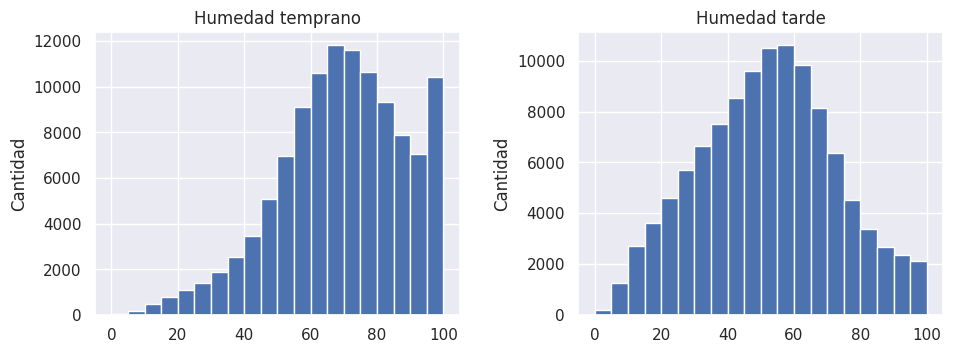

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 4], dpi=100)

dataset.humedad_temprano.plot(kind= 'hist', ax= axes[0], bins=20)
axes[0].set_title("Humedad temprano")
axes[0].set_ylabel("Cantidad")

dataset.humedad_tarde.plot(kind= 'hist', ax= axes[1],bins=20)
axes[1].set_title("Humedad tarde")
axes[1].set_ylabel("Cantidad")

plt.tight_layout(pad=2)
plt.show()

Notamos que la humedad temprano tiende a ser alta, con sus cantidades más representativas entre 50 y 100, mientras que la tarde tiene una distribución en forma de campana. Para ambos casos utilizaremos el promedio para rellenar los valores faltantes, considerando que no modificará la distribución. Además, es importante tener en cuenta que el porcentaje de missings es realmente bajo.

In [15]:
media_humedad_temprano = dataset['humedad_temprano'].mean()
media_humedad_tarde = dataset['humedad_tarde'].mean()

dataset['humedad_temprano'].fillna(value=media_humedad_temprano, inplace=True)
dataset['humedad_tarde'].fillna(value=media_humedad_tarde, inplace=True)

pd.Series(data=[media_humedad_temprano, media_humedad_tarde], index=['Humedad Temprano', 'Humedad Tarde']).to_frame('Media')

,Media
Humedad Temprano,68.834353
Humedad Tarde,51.468331


### Missings en Presiones atmosféricas

In [24]:
print("El porcentaje de missings en Presion at. temprano es:",(dataset.presion_atmosferica_temprano.isnull()).mean().round(4)*100,"%")
print("El porcentaje de missings en Presion at. tarde es:",(dataset.presion_atmosferica_tarde.isnull()).mean().round(4)*100,"%")

El porcentaje de missings en Presion at. temprano es: 9.83 %
El porcentaje de missings en Presion at. tarde es: 9.81 %


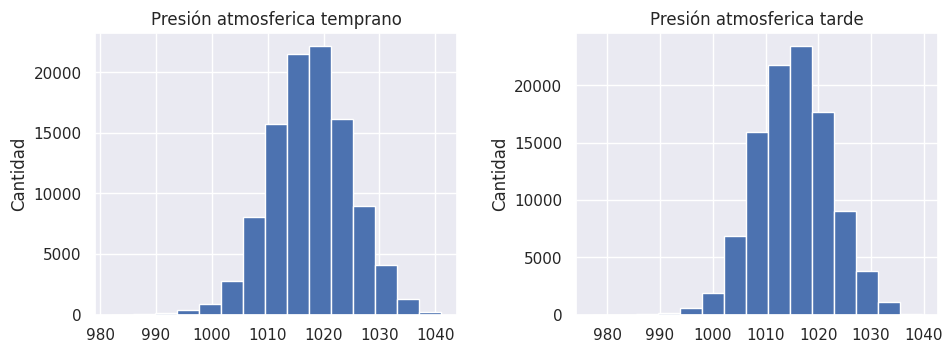

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 4], dpi=100)

dataset.presion_atmosferica_temprano.plot(kind= 'hist', ax= axes[0], bins=15)
axes[0].set_title("Presión atmosferica temprano")
axes[0].set_ylabel("Cantidad")

dataset.presion_atmosferica_tarde.plot(kind= 'hist', ax= axes[1],bins=15)
axes[1].set_title("Presión atmosferica tarde")
axes[1].set_ylabel("Cantidad")

plt.tight_layout(pad=2)
plt.show()

Notamos en ambos casos una distribución en forma de campana con, tal vez, un poco de ruido para cantidades bajas. Ambos casos tienen también el rango de valores muy similares, por no decir el mismo. Tomaremos el promedio para asignarlo a los valores faltantes dado a que la gran mayoria de los registros están concentrados en el rango [995,1035] aproximadamente.

In [16]:
media_presion_at_temprano = dataset['presion_atmosferica_temprano'].mean()
media_presion_at_tarde = dataset['presion_atmosferica_tarde'].mean()

dataset['presion_atmosferica_temprano'].fillna(value=media_presion_at_temprano, inplace=True)
dataset['presion_atmosferica_tarde'].fillna(value=media_presion_at_tarde, inplace=True)

pd.Series(data=[media_presion_at_temprano, media_presion_at_tarde], index=['Presión Atmosférica Temprano', 'Presión Atmosférica Tarde']).to_frame('Media')

,Media
Presión Atmosférica Temprano,1017.661372
Presión Atmosférica Tarde,1015.263406


### Missings en mediciones sobre el Viento

In [27]:
print("El porcentaje de missings en Velocidad max rafaga de viento es:",
      ((dataset.rafaga_viento_max_velocidad.isnull()).mean()*100).round(4),"%")
print("El porcentaje de missings en Velocidad viento temprano es:",
      ((dataset.velocidad_viendo_temprano.isnull()).mean()* 100).round(4),"%")
print("El porcentaje de missings en Velocidad viento tarde es:",
      ((dataset.velocidad_viendo_tarde.isnull()).mean()*100).round(4),"%")

El porcentaje de missings en Velocidad max rafaga de viento es: 6.5149 %
El porcentaje de missings en Velocidad viento temprano es: 0.9444 %
El porcentaje de missings en Velocidad viento tarde es: 1.8395 %


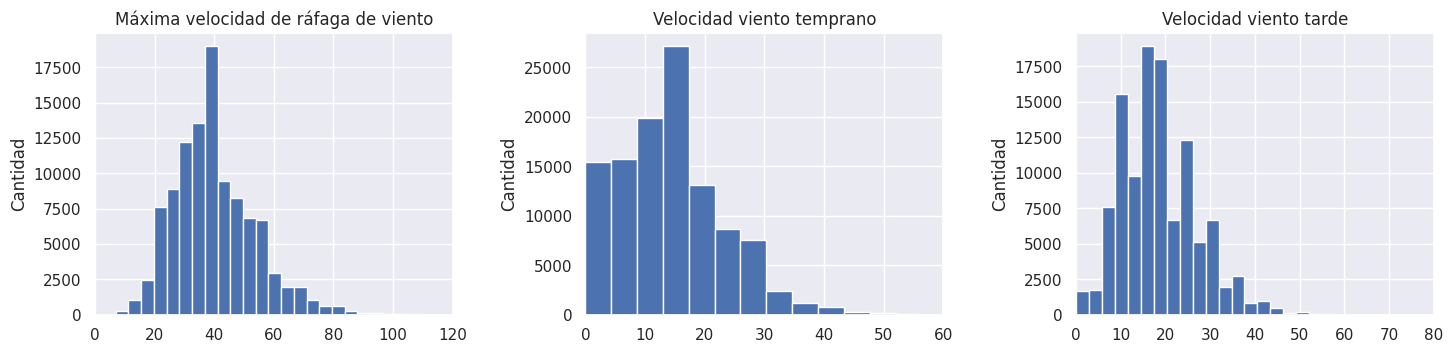

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[15, 4], dpi=100)

dataset.rafaga_viento_max_velocidad.plot(kind= 'hist', ax= axes[0], bins=30, xlim=(0,120))
axes[0].set_title("Máxima velocidad de ráfaga de viento")
axes[0].set_ylabel("Cantidad")

dataset.velocidad_viendo_temprano.plot(kind= 'hist', ax= axes[1], bins=30, xlim=(0,60))
axes[1].set_title("Velocidad viento temprano")
axes[1].set_ylabel("Cantidad")

dataset.velocidad_viendo_tarde.plot(kind= 'hist', ax= axes[2], bins=30, xlim=(0,60))
axes[2].set_title("Velocidad viento tarde")
axes[2].set_ylabel("Cantidad")
axes[2].set_xticks(np.arange(0,90,10))
plt.tight_layout(pad=2)
plt.show()

* Para la máxima velocidad de ráfaga de viento, vemos que hay una notable concentración entre los 20km/h y 60km/h, siendo una gran minoría las muestras que están por fuera de este rango.  
* Algo similar ocurre con las velocidades de los vientos. Observamos que en el caso del viento temprano, la mayoría de los casos no superan los 20 km/h, con pocos casos hasta los 60km/h y existiendo algunos tal vez outliers llegando a los 120km/h. En el caso del viento tarde, observamos que la velocidad ronda los 20km/h (entre 10km/h y 30km/h). A diferencia del anterior, aquí los outliers llegan solo hasta 80km/h.  
  
Entonces, debido a que en los tres casos la mayoria de muestras se concentran en un rango de valores relativamente chico, vamos a utilizar el promedio para completar los missings values (los cuales ademas representan un porcentaje bastante pequeño)

In [17]:
media_rafaga_max = dataset['rafaga_viento_max_velocidad'].mean()
media_vel_viento_temprano = dataset['velocidad_viendo_temprano'].mean()
media_vel_viento_tarde = dataset['velocidad_viendo_tarde'].mean()

dataset['rafaga_viento_max_velocidad'].fillna(value=media_rafaga_max, inplace=True)
dataset['velocidad_viendo_temprano'].fillna(value=media_vel_viento_temprano, inplace=True)
dataset['velocidad_viendo_tarde'].fillna(value=media_vel_viento_tarde, inplace=True)

pd.Series(data=[media_rafaga_max, media_vel_viento_temprano, media_vel_viento_tarde], 
          index=['Rafaga Viento Max', 'Velocidad Viento Temprano', 'Velocidad Viento Tarde']).to_frame('Media')

,Media
Rafaga Viento Max,39.980831
Velocidad Viento Temprano,14.009720
Velocidad Viento Tarde,18.655547


### Missings en Temperaturas

In [30]:
print("El porcentaje de missings en Temperatura temprano es:",((dataset.temperatura_temprano.isnull()).mean()*100).round(4),"%")
print("El porcentaje de missings en Temperatura tarde es:",((dataset.temperatura_tarde.isnull()).mean()* 100).round(4),"%")
print("El porcentaje de missings en Temperatura mínima es:",((dataset.temp_min.isnull()).mean()*100).round(4),"%")
print("El porcentaje de missings en Temperatura máxima es:",((dataset.temp_max.isnull()).mean()* 100).round(4),"%")

El porcentaje de missings en Temperatura temprano es: 0.6349 %
El porcentaje de missings en Temperatura tarde es: 1.916 %
El porcentaje de missings en Temperatura mínima es: 0.4458 %
El porcentaje de missings en Temperatura máxima es: 0.2198 %


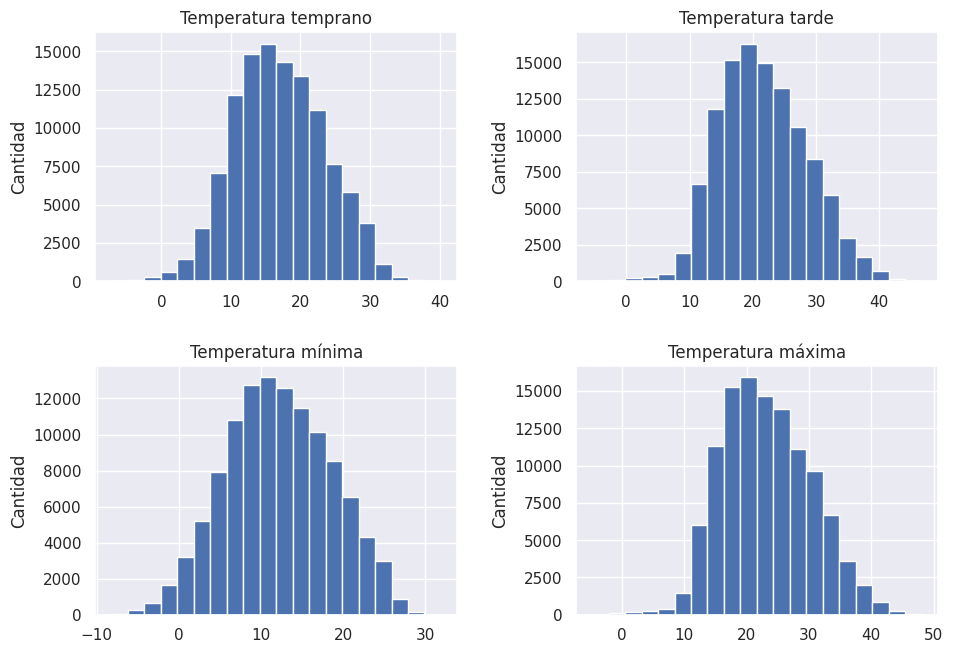

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[10, 7], dpi=100)

dataset.temperatura_temprano.plot(kind= 'hist', ax= axes[0][0], bins=20)
axes[0][0].set_title("Temperatura temprano")
axes[0][0].set_ylabel("Cantidad")

dataset.temperatura_tarde.plot(kind= 'hist', ax= axes[0][1], bins=20)
axes[0][1].set_title("Temperatura tarde")
axes[0][1].set_ylabel("Cantidad")

dataset.temp_min.plot(kind= 'hist', ax= axes[1][0], bins=20)
axes[1][0].set_title("Temperatura mínima")
axes[1][0].set_ylabel("Cantidad")

dataset.temp_max.plot(kind= 'hist', ax= axes[1][1], bins=20)
axes[1][1].set_title("Temperatura máxima")
axes[1][1].set_ylabel("Cantidad")
plt.tight_layout(pad=2)
plt.show()

Para los cuatro casos vemos que se presenta una distribución en forma de campana donde la mayor parte de las muestras se concentran en un rango intermedio de los valores posibles. Por eso, consideramos que lo más acertado para los missing values restantes es reemplazarlos por el promedio de su feature correspondiente 

In [18]:
media_temp_temprano = dataset['temperatura_temprano'].mean()
media_temp_tarde = dataset['temperatura_tarde'].mean()
media_temp_min = dataset['temp_min'].mean()
media_temp_max = dataset['temp_max'].mean()

dataset['temperatura_temprano'].fillna(value=media_temp_temprano, inplace=True)
dataset['temperatura_tarde'].fillna(value=media_temp_tarde, inplace=True)
dataset['temp_min'].fillna(value=media_temp_min, inplace=True)
dataset['temp_max'].fillna(value=media_temp_max, inplace=True)

pd.Series(data=[media_temp_temprano, media_temp_tarde, media_temp_min, media_temp_max], 
          index=['Temperatura Temprano', 'Temperatura Tarde', 'Temperatura Min', 'Temperatura Max']).to_frame('Media')

,Media
Temperatura Temprano,16.999152
Temperatura Tarde,21.694329
Temperatura Min,12.195022
Temperatura Max,23.236078


### Missings en mm de Lluvia y mm de Agua evaporada

In [33]:
print("El porcentaje de missings en mm de Lluvia en el dia es:",((dataset.mm_lluvia_dia.isnull()).mean()* 100).round(4),"%")
print("El porcentaje de missings en mm Agua evaporada es:",((dataset.mm_evaporados_agua.isnull()).mean()*100).round(4),"%")

El porcentaje de missings en mm de Lluvia en el dia es: 0.9892 %
El porcentaje de missings en mm Agua evaporada es: 42.7623 %


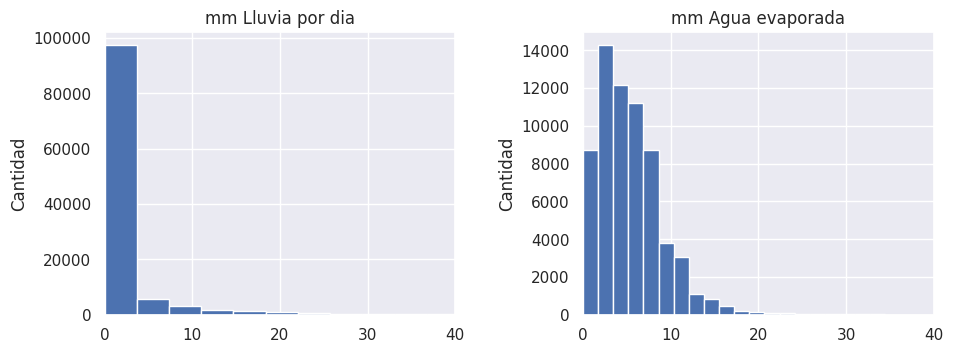

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 4], dpi=100)

dataset.mm_lluvia_dia.plot(kind= 'hist', ax= axes[0], bins=100, xlim=(0,40))
axes[0].set_title("mm Lluvia por dia")
axes[0].set_ylabel("Cantidad")

dataset.mm_evaporados_agua.plot(kind= 'hist', ax= axes[1], bins=50, xlim=(0,40))
axes[1].set_title("mm Agua evaporada")
axes[1].set_ylabel("Cantidad")

plt.tight_layout(pad=2)
plt.show()

Notamos que la cantidad de milimetros de agua llovida es en la gran mayoria de los casos nula. Hay algunos casos que llegan cerca de los 350 pero son bastante poco representativos. Para no inventar información en este caso, estableceremos la moda(0) a todos los valores nulos de dicha columna. En el caso del agua evaporada, los casos más grandes pueden llegar hasta 80mm, pero al igual que en el caso anterior, son los menos representativos, en este caso colocaremos la mediana, ya que si bien la mayoria contiene 0mm, tambien es verdad que hay proporciones significativas con un poco más de lluvia.

In [19]:
dataset['mm_lluvia_dia'].fillna(value=0, inplace=True)
dataset['mm_evaporados_agua'].fillna(value=dataset['mm_evaporados_agua'].median(), inplace=True)

In [20]:
mediana_mm_evaporados = dataset['mm_evaporados_agua'].median()
media_mm_evaporados = dataset['mm_evaporados_agua'].mean()

dataset['mm_lluvia_dia'].fillna(value=0, inplace=True)
dataset['mm_evaporados_agua'].fillna(value=mediana_mm_evaporados, inplace=True)

pd.DataFrame({'Mediana':[mediana_mm_evaporados],'Media':[media_mm_evaporados]}, index=['mm evaporados de agua'] )

,Mediana,Media
mm evaporados de agua,4.8,5.181636


Observación: También analizamos si habia valores no válidos para alguno de los features numéricos (valores negativos), y sólo aparecían en los cuatro features de temperatura y con valores razonables: ninguno superaba los -10ºC

### Missing values en variables categóricas

Ahora nos ocupamos de los missing values en las variables categóricas. En estos casos, como no podemos hacer uso de la estadística simplemente reemplazamos los valores 'NaN' por una nueva categoría llamada 'Sin datos'

In [21]:
columnas_categoricas_con_nan = dataset.columns[(dataset.dtypes == 'object') & (dataset.isnull().any()) ]

for col in columnas_categoricas_con_nan:
    dataset[col].fillna(value='Sin datos', inplace=True)

Finalmente, chequeamos de no tener algun missing value en las columnas no numéricas representado con algún valor no válido, por ejemplo algun número o algun caracter como '-'. 

In [22]:
columnas_no_numericas = dataset.select_dtypes(include=['object']).columns
for col in columnas_no_numericas:
    print(dataset[col].str.contains('1|2|3|4|5|6|7|8|9|0|-|#|%|&|!|@').any())  

False
False
False
False
False
False
False


Viendo que los datos de todas las columnas están completos, podemos empezar a hacernos preguntas y buscar ideas que nos permitan determinar si al dia siguiente lloverán hamburguesas o no.

In [23]:
dataset.reset_index(inplace=True)
dataset.drop(axis=1, columns='index', inplace=True)

## Análisis Exploratorio: Relaciones entre variables y target

## ¿Que relación hay entre todas las temperaturas presentes?

La intuición nos dice que es de esperar que, al no haber estado presente durante toda la noche el sol, la mañana es el momento donde se debería presentar la menor temperatura. Ahora bien, la intuición tambien dice que la correlación entre la temperatura máxima y la temperatura tarde deberían ser altas, ya que es ahí cuando el sol ha estado calentando la tierra el mayor tiempo posible y está en su momento más activo.  
¿El set de datos que tenemos respalda esta idea? Para visualizarlo utilizaremos la correlación entre las temperaturas minimas y maximas, con las temperaturas temprano y tarde, y lo mostraremos mediante un heatmap.

<AxesSubplot:>

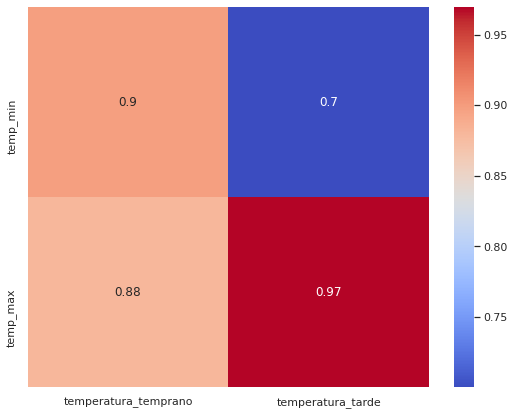

In [40]:
sns.heatmap(dataset[['temp_min','temp_max', 'temperatura_temprano', 'temperatura_tarde']]
            .corr()[:-2].drop(['temp_min','temp_max'],axis=1), 
            annot = True, 
            fmt='.2g',
            cmap= 'coolwarm')

Efectivamente, este mapa arroja que nuestra intuición fue acertada.

## ¿Hay maneras más eficientes de predecir si llueve que tirar una moneda?

Para empezar, analizamos la proporción de dias en los que al siguiente llovieron hamburguesas.

In [41]:
dataset.llovieron_hamburguesas_al_dia_siguiente.value_counts().to_frame('¿Llovieron hamburguesas al dia siguiente?')

,¿Llovieron hamburguesas al dia siguiente?
no,88277
si,25447


Notamos una mayor proporcion de dias que al siguiente no llovieron que los que si. Para poder visualizarlo mejor, lo volcamos en un gráfico.

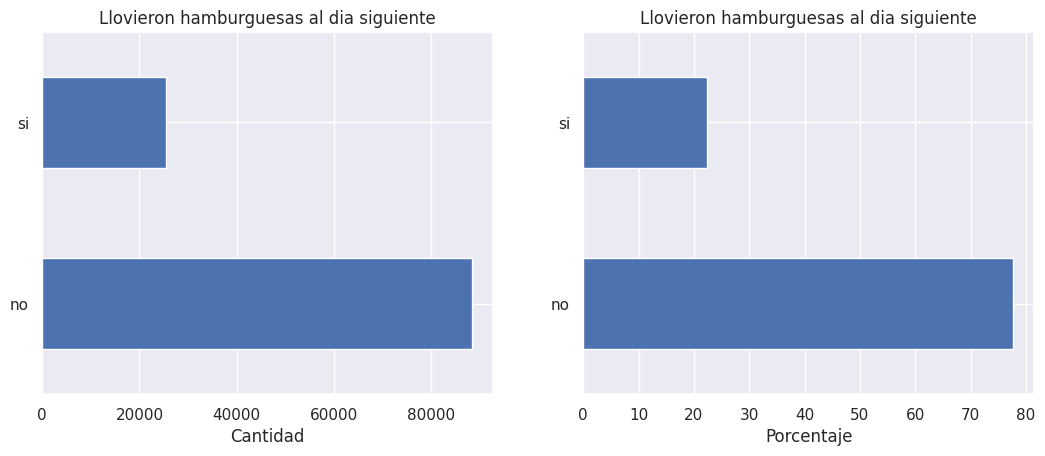

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

dataset.llovieron_hamburguesas_al_dia_siguiente.value_counts().plot(kind= 'barh', ax= axes[0])
axes[0].set_title("Llovieron hamburguesas al dia siguiente")
axes[0].set_xlabel("Cantidad")

dataset.llovieron_hamburguesas_al_dia_siguiente.value_counts().div(dataset.pipe(len)).mul(100).plot(kind='barh', ax=axes[1])
axes[1].set_title("Llovieron hamburguesas al dia siguiente")
axes[1].set_xlabel("Porcentaje")

plt.show()

Esto es casi un 80%, es decir que si nuestra predicción es siempre que al dia siguiente no va a llover, lograríamos una certeza más alta que tirando una moneda, es decir, 50%. Lo comprobamos obteniendo la certeza al decir siempre que no lloverá con el dataset.

In [43]:
pred = pd.Series(np.zeros(len(dataset))).replace({1: "si", 0: "no"})
accuracy_score(dataset.llovieron_hamburguesas_al_dia_siguiente, pred)

0.7762389645105694

## Que hoy llueva, ¿implica que mañana también?

Desde la intuición pensamos que es probable que si un dia llovió, al otro tambien lo haga. Es por esto que buscaremos si existe algún patrón evidente.

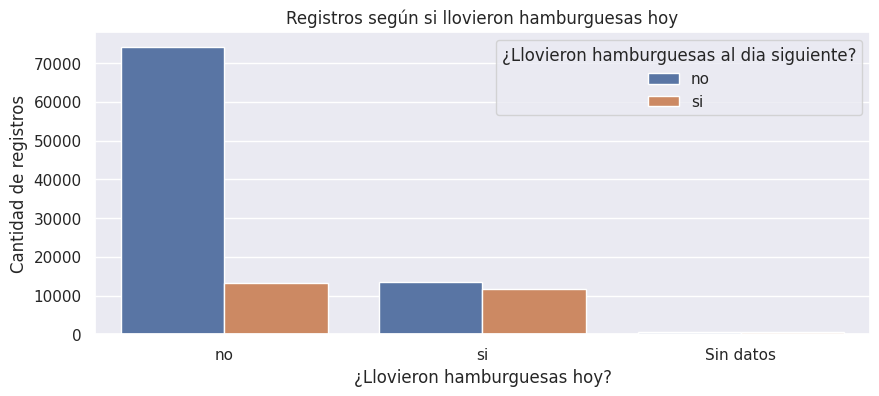

In [44]:
plt.figure(figsize=[10 , 4], dpi=100)
sns.countplot(data=dataset, 
              x='llovieron_hamburguesas_hoy', 
              hue='llovieron_hamburguesas_al_dia_siguiente',)
plt.title("Registros según si llovieron hamburguesas hoy")
plt.ylabel("Cantidad de registros")
plt.xlabel("¿Llovieron hamburguesas hoy?")
plt.legend(title="¿Llovieron hamburguesas al dia siguiente?")

plt.show()

Las conclusiones que podemos sacar no acompañan mucho la intuición inicial, debido a que sabiendo que hoy llovió hay casi igual probabilidad de que al día siguiente lluevan o no hamburguesas. De hecho, es ligeramente mayor la probabilidad de que NO lluevan al dia siguiente, si hoy llovió.

H: "Hoy llovieron hamburguesas"  
M: "Mañana lloverán hamburguesas"  
$$
P(M | H) = \frac{P(M,H)}{P(H)}
$$

In [45]:
h = (dataset.llovieron_hamburguesas_hoy == 'si')
m = (dataset.llovieron_hamburguesas_al_dia_siguiente == 'si')
P_h_m = sum(m & h)/len(dataset)
P_h = sum(h)/len(dataset)

print("La probabilidad de que al dia siguiente lluevan hamburguesas, sabiendo que hoy llovió es de: ",round(P_h_m/P_h,4))

La probabilidad de que al dia siguiente lluevan hamburguesas, sabiendo que hoy llovió es de:  0.4637


Esta conclusión no es lo suficientemente determinante para ayudarnos a mejorar la predicción.  Por otro lado, es interesante notar que si hoy no llovió hamburguesas, hay una alta probabilidad de que mañana tampoco lo haga:

In [46]:
not_h = (dataset.llovieron_hamburguesas_hoy == 'no')
not_m = (dataset.llovieron_hamburguesas_al_dia_siguiente == 'no')
P_not_h_not_m = sum(not_m & not_h)/len(dataset)
P_not_h = sum(not_h)/len(dataset)

print("La probabilidad de que al dia siguiente no lluevan hamburguesas, sabiendo que hoy no llovió es de: ",round(P_not_h_not_m/P_not_h,4))

La probabilidad de que al dia siguiente no lluevan hamburguesas, sabiendo que hoy no llovió es de:  0.8482


## ¿La nubosidad y la humedad tienen relación directa con la lluvia de hamburguesas?
Para comprobar si hay una relación, analizaremos la variación de todos estos valores, según si al dia siguiente llovió o no: Nubosidad tarde, nubosidad temprano, humedad tarde, humedad temprano. Como todas estas son distribuciones continuas, las mostraremos mediante un histograma.

Empezaremos con la nubosidad temprano. En principio, dividiremos la información en un dataset que contenga los dias que al otro dia sí llovio, y uno en el que no.

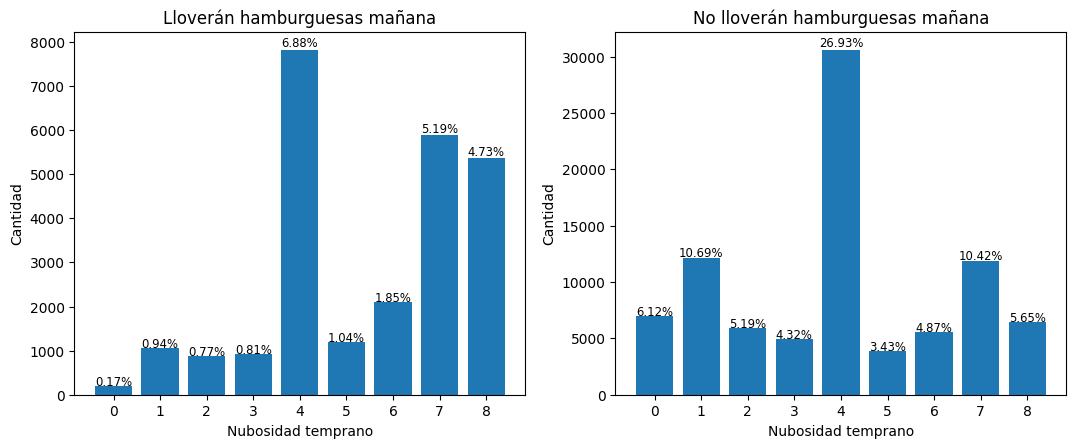

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

dataset_llovio = dataset[dataset.llovieron_hamburguesas_al_dia_siguiente == 'si']
dataset_llovio_nub_temp = dataset_llovio.groupby('nubosidad_temprano').agg({'barrio':'count'}).rename(columns={'barrio':'cantidad_de_casos'})

dataset_no_llovio = dataset[dataset.llovieron_hamburguesas_al_dia_siguiente == 'no']
dataset_no_llovio_nub_temp = dataset_no_llovio.groupby('nubosidad_temprano').agg({'barrio':'count'}).rename(columns={'barrio':'cantidad_de_casos'})


graph1 = axes[0].bar(dataset_llovio_nub_temp.index, dataset_llovio_nub_temp.cantidad_de_casos)
axes[0].set_title("Lloverán hamburguesas mañana")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Nubosidad temprano")
axes[0].set_xticks([0,1,2,3,4,5,6,7,8])

i=0  
for p1 in graph1:    
    width = p1.get_width()
    height = p1.get_height()
    x, y = p1.get_xy()

    axes[0].text(x+width/2,
             y+height*1.01,
             str(round(dataset_llovio_nub_temp.cantidad_de_casos[i]*100/len(dataset),2))+'%',
             ha='center',
             size='small',)
    i += 1

graph2 = axes[1].bar(dataset_no_llovio_nub_temp.index, dataset_no_llovio_nub_temp.cantidad_de_casos)
axes[1].set_title("No lloverán hamburguesas mañana")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Nubosidad temprano")
axes[1].set_xticks([0,1,2,3,4,5,6,7,8])

i=0  
for p2 in graph2:    
    width2 = p2.get_width()
    height2 = p2.get_height()
    x2, y2 = p2.get_xy()

    axes[1].text(x2+width2/2,
             y2+height2*1.01,
             str(round(dataset_no_llovio_nub_temp.cantidad_de_casos[i]*100/len(dataset),2))+'%',
             ha='center',
             size='small',)
    i += 1

plt.show()

Un poco acompañando a la intuición, observamos que si al dia siguiente lloverán hamburguesas, hay bastantes casos donde la nubosidad es elevada, pero esta relación es unidireccional. Sin embargo, en cantidades totales, los dias con nubosidad temprano 8 o 7 son mayoritariamente no target (lo cual explayaremos al analizar la nubosidad por la tarde), por ello no podemos extraer nada determinista que nos permita mejorar la certeza.

In [147]:
nubosidad_alta = (dataset.nubosidad_temprano == 7) | (dataset.nubosidad_temprano == 8)

llovio = 100*sum( nubosidad_alta & (dataset.llovieron_hamburguesas_al_dia_siguiente == 'si'))/len(dataset)
no_llovio = 100*sum( nubosidad_alta & (dataset.llovieron_hamburguesas_al_dia_siguiente == 'no'))/len(dataset)
pd.Series(data=[llovio, no_llovio], index=['Llovieron hamburguesas al dia sgte', 'No llovieron hamburguesas al dia sgte']).to_frame('% Nubosidades altas (7 u 8)')

,% Nubosidades altas (7 u 8)
Llovieron hamburguesas al dia sgte,9.914354
No llovieron hamburguesas al dia sgte,16.062573


Ahora veremos la nubosidad tarde

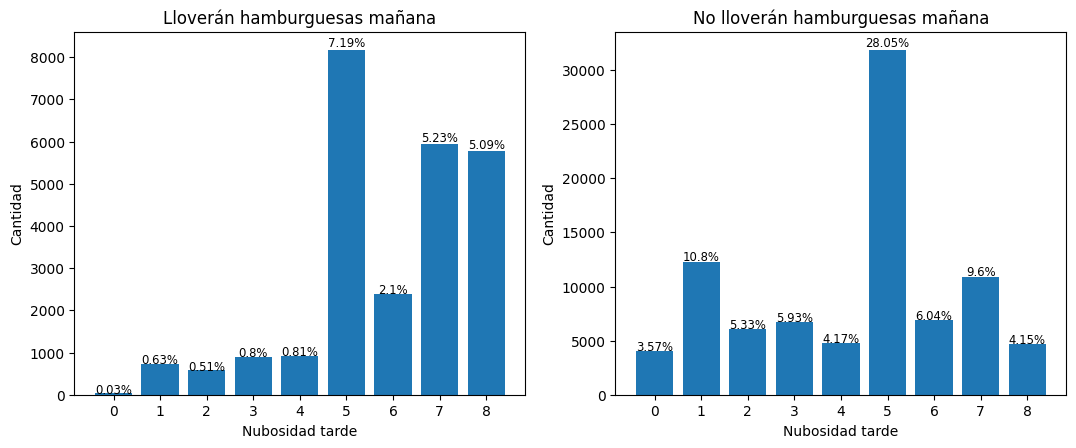

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

dataset_llovio_nub_tarde = dataset_llovio.groupby('nubosidad_tarde').agg({'barrio':'count'}).rename(columns={'barrio':'cantidad_de_casos'})
dataset_no_llovio_nub_tarde = dataset_no_llovio.groupby('nubosidad_tarde').agg({'barrio':'count'}).rename(columns={'barrio':'cantidad_de_casos'})

graph1 = axes[0].bar(dataset_llovio_nub_tarde.index, dataset_llovio_nub_tarde.cantidad_de_casos)
axes[0].set_title("Lloverán hamburguesas mañana")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Nubosidad tarde")
axes[0].set_xticks([0,1,2,3,4,5,6,7,8])

i=0  
for p1 in graph1:    
    width = p1.get_width()
    height = p1.get_height()
    x, y = p1.get_xy()

    axes[0].text(x+width/2,
             y+height*1.01,
             str(round(dataset_llovio_nub_tarde.cantidad_de_casos[i]*100/len(dataset),2))+'%',
             ha='center',
             size='small',)
    i += 1

graph2 = axes[1].bar(dataset_no_llovio_nub_tarde.index, dataset_no_llovio_nub_tarde.cantidad_de_casos)
axes[1].set_title("No lloverán hamburguesas mañana")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Nubosidad tarde")
axes[1].set_xticks([0,1,2,3,4,5,6,7,8])
    
i=0  
for p2 in graph2:    
    width2 = p2.get_width()
    height2 = p2.get_height()
    x2, y2 = p2.get_xy()

    axes[1].text(x2+width2/2,
             y2+height2*1.01,
             str(round(dataset_no_llovio_nub_tarde.cantidad_de_casos[i]*100/len(dataset),2))+'%',
             ha='center',
             size='small',)
    i += 1

plt.show()

La distribución es similar al caso anterior, con una gran concentración de muestras con nubosidades 5 aunque esto se debe principalmente al imputer. Además, vemos que los dias que llueven hamburguesas al día siguiente suelen presentar nubosidades más altas (7 y 8). Sin embargo, si lo analizamos desde los porcentajes (sobre el total de muestras), vemos que no representan un gran porcentaje, de hecho hay mas muestras con nubosidades 7 y 8 en las que NO llueven hamburguesas al día siguiente, con lo cual no nos sirve para sacar una conclusión fuerte a la hora de predecir la variable target. Lo único que nos aporta es que sabiendo que al otro día llueven hamburguesas, entonces es probable que hoy haya nubosidad alta (7 u 8), pero esta relación no nos sirve para predecir (no es un "sí y sólo sí").

Ahora analizaremos la humedad temprano

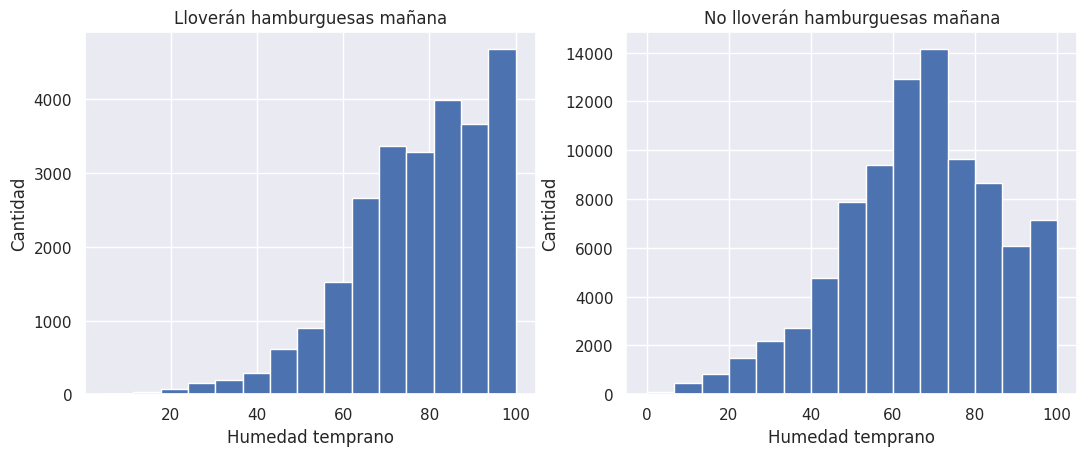

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

dataset_llovio.humedad_temprano.plot(kind= 'hist', ax= axes[0], bins=15)
axes[0].set_title("Lloverán hamburguesas mañana")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Humedad temprano")

dataset_no_llovio.humedad_temprano.plot(kind= 'hist', ax= axes[1], bins=15)
axes[1].set_title("No lloverán hamburguesas mañana")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Humedad temprano")

plt.show()

De los dias en los que al otro día llovieron hamburguesas notamos una distribución ascendente, con mayor cantidad de dias a mayor humedad temprano. Esto no es suficiente para poder catalogar la humedad temprano alta en alguna de las clases (lloverá/no lloverá) de manera determinista. Esto debido a que la humedad temprano de los dias que no llovió al siguiente también presenta cantidades altas, siendo una propiedad presente en ambas clases.

Ahora analizaremos la humedad tarde

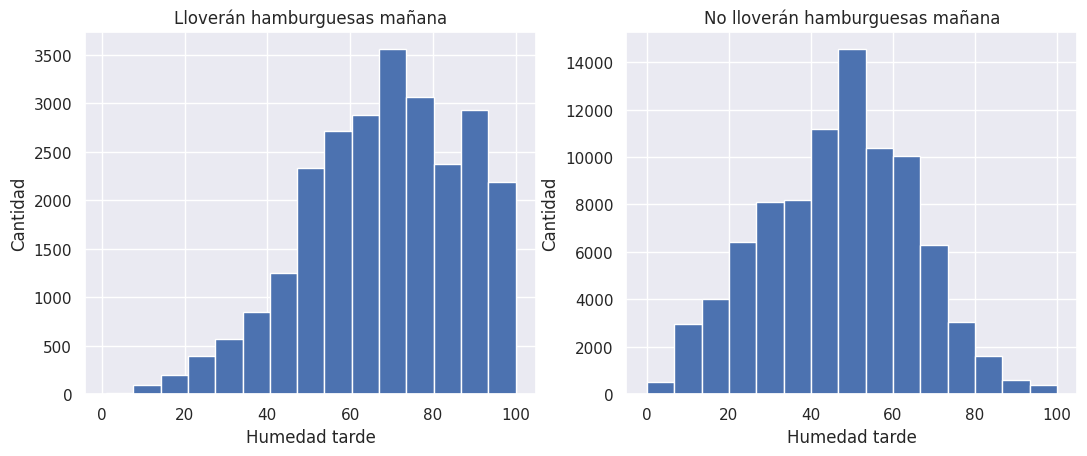

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

dataset_llovio.humedad_tarde.plot(kind= 'hist', ax= axes[0], bins=15)
axes[0].set_title("Lloverán hamburguesas mañana")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Humedad tarde")

dataset_no_llovio.humedad_tarde.plot(kind= 'hist', ax= axes[1], bins=15)
axes[1].set_title("No lloverán hamburguesas mañana")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Humedad tarde")

plt.show()

Acá es donde notamos una primera gran diferencia. La cantidad de dias cuya humedad tarde es muy alta en el grupo en donde al siguiente día no llovió es significativamente más baja. Es por eso que podemos empezar a hacer una aproximación, tanteando y prediciendo que para una humedad mayor a 79 al dia siguiente lloverán hamburguesas. Ahora obtenemos una certeza del 82,3%.

In [52]:
pred = pd.Series(np.zeros(len(dataset))).replace({1: "si", 0: "no"})
pred[(dataset.humedad_tarde >= 79)] = 'si'
accuracy_score(dataset.llovieron_hamburguesas_al_dia_siguiente, pred)

0.8236256199219162

## ¿La estación del año tendrá relevancia?

Teniendo en cuenta que la lluvia de hamburguesa parece compartir ciertos factores con la lluvia normal, vamos a analizar cómo se comporta la lluvia de hamburguesas dependiendo la estación del año en que nos encontremos. Para ello vamos a observar el porcentaje de lluvias de hamburguesa registradas en cada estación.  

Creemos que puede ser útil debido a que existen estaciones donde suele haber mas precipitaciones que en otras, por lo que intuimos que otoño y tal vez invierno sean las dos mas lluviosas.

In [53]:
def porcentaje_lluvia(llovio_hamburguesas_al_dia_siguiente):
    return (llovio_hamburguesas_al_dia_siguiente == 'si').mean()*100

porcentaje_lluvia_en_estaciones = dataset.groupby('estacion').agg({'llovieron_hamburguesas_al_dia_siguiente':porcentaje_lluvia})

#Pasamos el DataFrame a Serie para poder plotear
porcentaje_lluvia_en_estaciones = porcentaje_lluvia_en_estaciones['llovieron_hamburguesas_al_dia_siguiente']

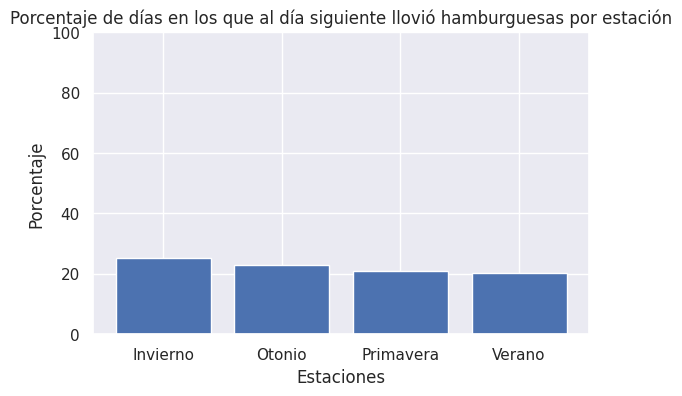

In [54]:
plt.figure(figsize=(6.4,4), dpi=100)
plt.bar(porcentaje_lluvia_en_estaciones.index, porcentaje_lluvia_en_estaciones.values)
plt.ylabel("Porcentaje")
plt.xlabel("Estaciones")
plt.ylim(0, 100)
plt.title('Porcentaje de días en los que al día siguiente llovió hamburguesas por estación')
plt.show()

Observando los resultados vemos que si bien invierno y otoño fueron las mas lluviosas, la diferencia con respecto a las otras estaciones fue muy pequeña. Por lo tanto, contrario a lo que ituimos en un principio, concluimos que hubo un porcentaje de lluvias hamburguesas similar para cada estación lo cual no nos aporta mucha información para realizar la predicción que buscamos.  

Para finalizar el análisis que relaciona las fechas con la lluvia de hamburguesas, proponemos ver el porcentaje de que lluevan hamburguesas al dia siguiente para cada mes del año. Este analisis es un poco más fino que el de las estaciones y tal vez obtengamos información relevante. 

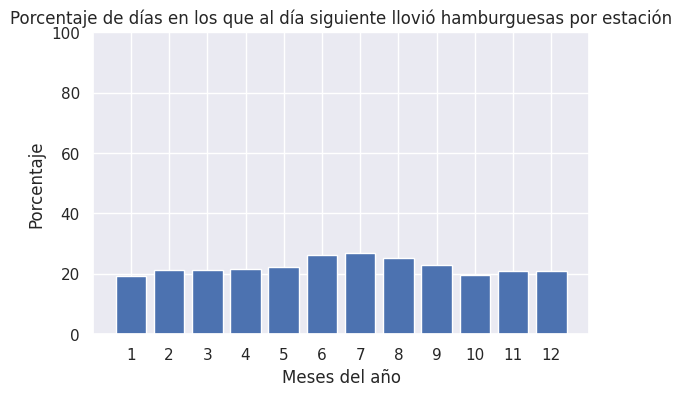

In [55]:
df_meses = pd.DataFrame({'mes_de_registro':dataset.dia.dt.month,
                        'llovieron_hamburguesas_al_dia_siguiente':dataset.llovieron_hamburguesas_al_dia_siguiente})
df_meses = df_meses.groupby('mes_de_registro').agg({'llovieron_hamburguesas_al_dia_siguiente':porcentaje_lluvia})

plt.figure(figsize=(6.4,4), dpi=100)
plt.bar(df_meses.index, df_meses.llovieron_hamburguesas_al_dia_siguiente)
plt.ylabel("Porcentaje")
plt.xlabel("Meses del año")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.ylim(0, 100)
plt.title('Porcentaje de días en los que al día siguiente llovió hamburguesas por estación')
plt.show()

Sin embargo, tampoco nos resulta del todo útil pues todos los meses poseen porcentajes parecidos.

## Se sabe que cuando llueve normalmente baja la temperatura, ¿la lluvia de hamburguesas provocará disminución de temperatura?

Para empezar, analizaremos la diferencia de temperatura minima entre dias con el target al que apuntamos versus las que no.

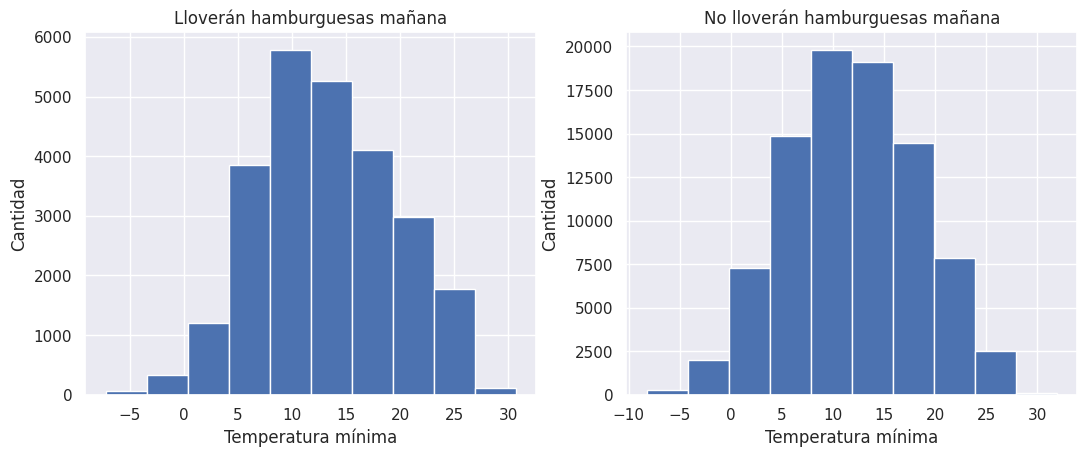

In [143]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

dataset_llovio.temp_min.plot(kind= 'hist', ax= axes[0], bins=10)
axes[0].set_title("Lloverán hamburguesas mañana")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Temperatura mínima")

dataset_no_llovio.temp_min.plot(kind= 'hist', ax= axes[1], bins=10)
axes[1].set_title("No lloverán hamburguesas mañana")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Temperatura mínima")

plt.show()

Podemos observar las distribuciones son muy similares por lo que no podemos extraer información relevante. Veamos que ocurre con la temperatura máxima.

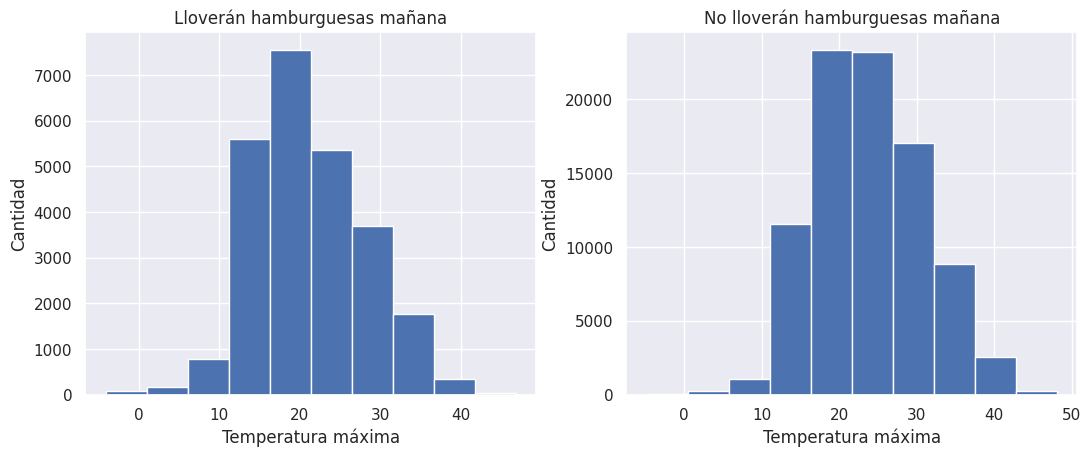

In [144]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

dataset_llovio.temp_max.plot(kind= 'hist', ax= axes[0], bins=10)
axes[0].set_title("Lloverán hamburguesas mañana")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Temperatura máxima")

dataset_no_llovio.temp_max.plot(kind= 'hist', ax= axes[1], bins=10)
axes[1].set_title("No lloverán hamburguesas mañana")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Temperatura máxima")

plt.show()

Ocurre algo muy similar, por lo que tampoco podemos extraer información de este atributo. Ahora veamos que ocurre con la temperatura que toma Flint cuando se levanta a la mañana.

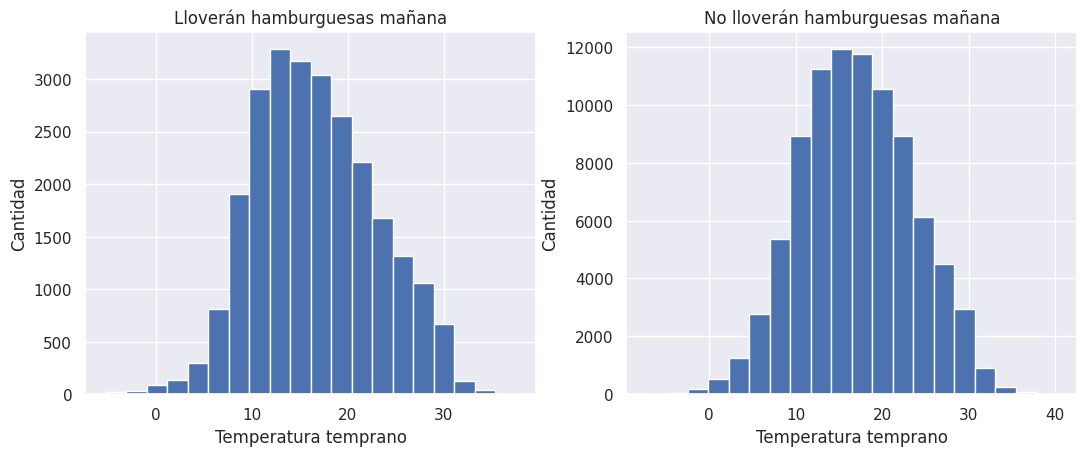

In [145]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

dataset_llovio.temperatura_temprano.plot(kind= 'hist', ax= axes[0], bins=20)
axes[0].set_title("Lloverán hamburguesas mañana")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Temperatura temprano")

dataset_no_llovio.temperatura_temprano.plot(kind= 'hist', ax= axes[1], bins=20)
axes[1].set_title("No lloverán hamburguesas mañana")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Temperatura temprano")

plt.show()

Podemos observar como detalle que en los dias target no se presentan temperaturas temprano que llegen a los 40 grados centigrados. Por lo tanto, podríamos descartar aquellos dias que si lo hacen. Sin embargo como empezamos asumiendo que no lloverán(gracias al experimento de la moneda), esta información no agrega utilidad.

Ahora veamos que ocurre con la temperatura tarde.

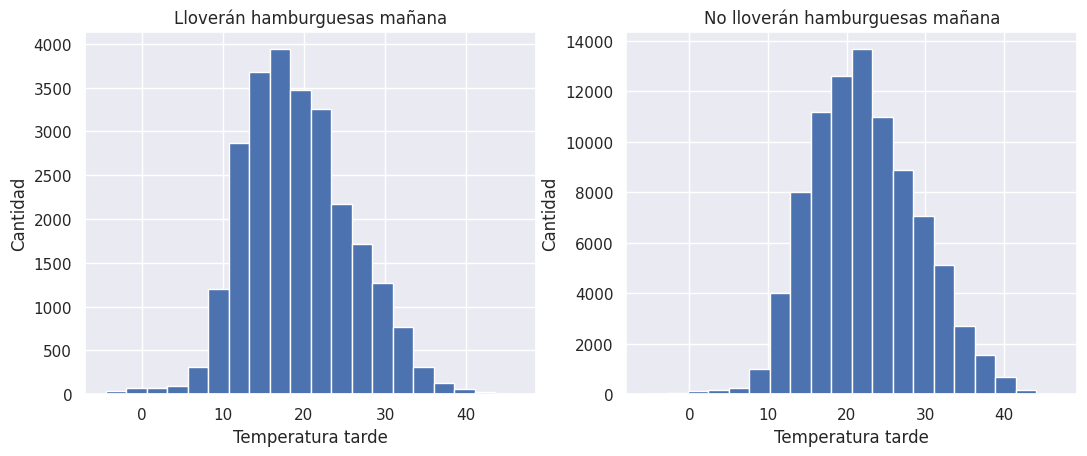

In [146]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

dataset_llovio.temperatura_tarde.plot(kind= 'hist', ax= axes[0], bins=20)
axes[0].set_title("Lloverán hamburguesas mañana")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Temperatura tarde")

dataset_no_llovio.temperatura_tarde.plot(kind= 'hist', ax= axes[1], bins=20)
axes[1].set_title("No lloverán hamburguesas mañana")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Temperatura tarde")

plt.show()

Una vez mas observamos distribuciones bastante similares, con poca información que sea util para mejorar la predicción determinista.

### ¿Hay lluvia en todos los barrios? ¿Hay barrios con más lluvia de hamburguesas que en otros?

Para empezar, visualicemos la distribución de barrios en todo el dataset.

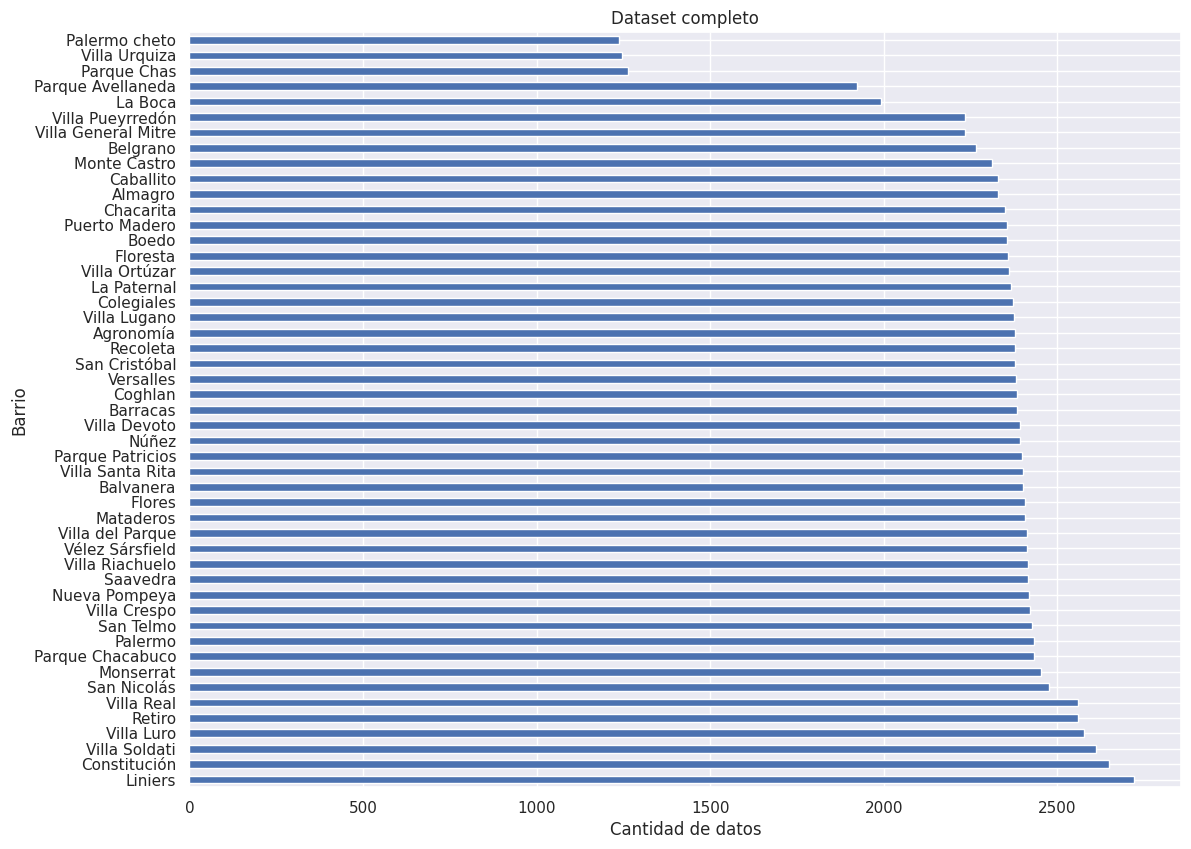

In [147]:
fig, ax = plt.subplots(figsize=[6.4 * 2, 10], dpi=100)

dataset.barrio.value_counts().plot(kind= 'barh', ax= ax)
ax.set_title("Dataset completo")
ax.set_ylabel("Barrio")
ax.set_xlabel("Cantidad de datos")

plt.show()

Notamos que las cantidades son bastante uniformes, entre 1400 y 2500 por barrio. Destacando los barrios de Palermo cheto, villa urquiza y parque chas como los que tienen menos cantidad de datos registrados, y Liniers y constitución como los que tienen más. Veamos especificamente los dias target a ver si podemos sacar alguna conclusión.

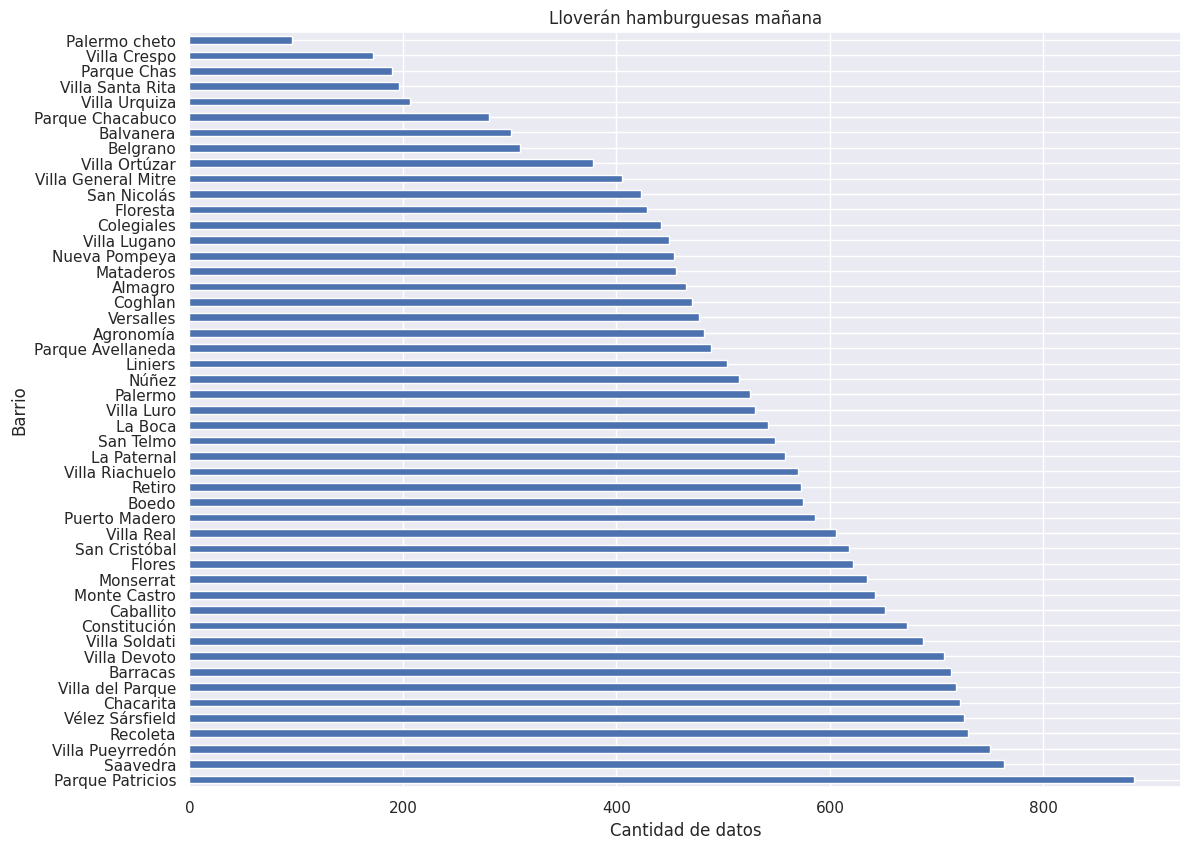

In [148]:
fig, ax = plt.subplots(figsize=[6.4 * 2, 10], dpi=100)

dataset_llovio.barrio.value_counts().plot(kind= 'barh', ax= ax)
ax.set_title("Lloverán hamburguesas mañana")
ax.set_ylabel("Barrio")
ax.set_xlabel("Cantidad de datos")

plt.show()

Notamos un rango parecido, entre 100 y 800 muestras de cada barrio. Entre los barrios con menos cantidad se encuentra palermo cheto y parque chas, que son a su vez de los que se tienen menos datos en el dataset total. No se puede todavia sacar ningun dato deterministico, solo se puede decir que es más probable que llueva en barrios como parque patricios, que en barrios como villa crespo. Ahora veamos como es el caso de los dias no target.

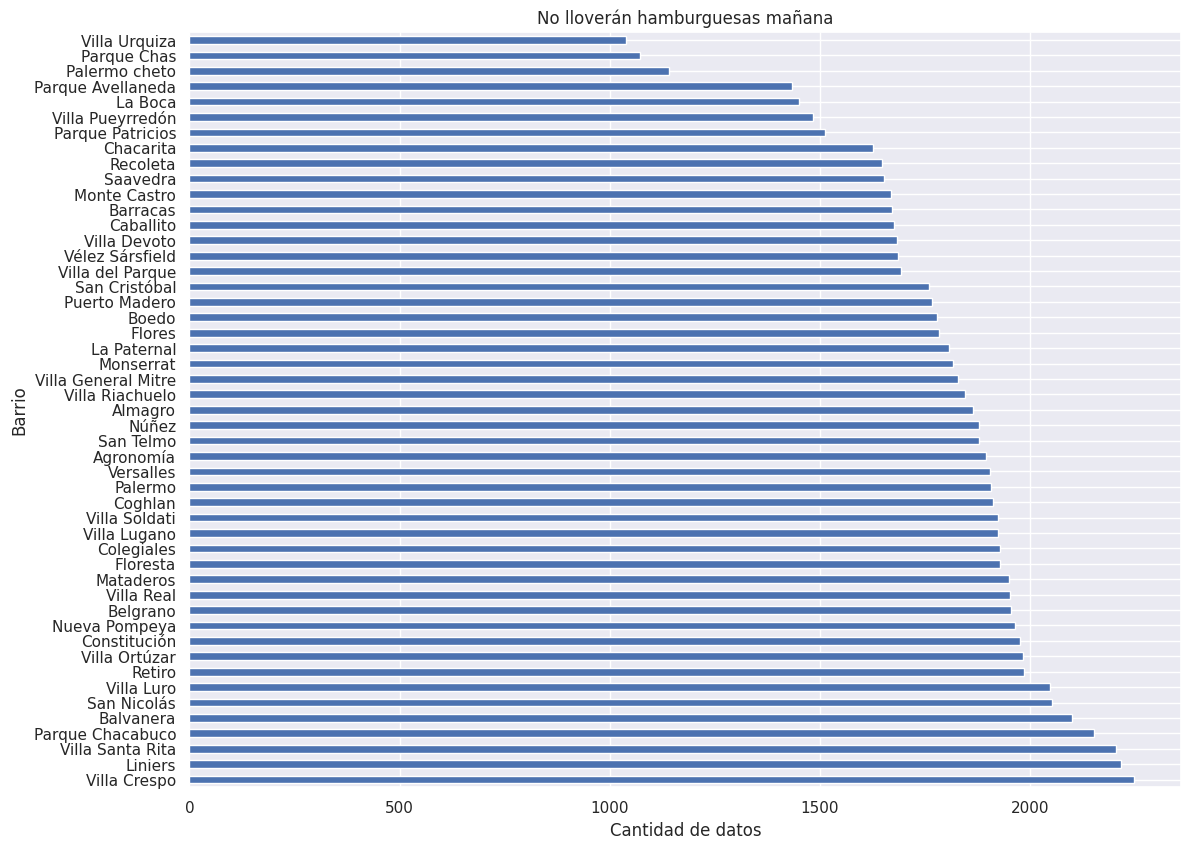

In [149]:
fig, ax = plt.subplots(figsize=[6.4 * 2, 10], dpi=100)

dataset_no_llovio.barrio.value_counts().plot(kind= 'barh', ax= ax)
ax.set_title("No lloverán hamburguesas mañana")
ax.set_ylabel("Barrio")
ax.set_xlabel("Cantidad de datos")

plt.show()

Bastante parecido al anterior con respecto a los barrios con menos cantidad de datos. Algunos detalles a destacar son que en barrios como villa crespo se presentan muchos dias que catalogan como no target, y en el que catalogarían como si target son los menos. Sin embargo no nos servirá para mejorar la predicción ya que partiremos desde el no.

## ¿Habrá otras caracteristicas en el dia que sean determinantes?

Preguntandonos esto, empezamos a indagar el resto de las columnas del dataset, analizandolas en principio y buscando que conclusiones podemos sacar a partir de eso.

### Velocidad del viento

En primer lugar, analizaremos la distribución de la velocidad del viento en general.

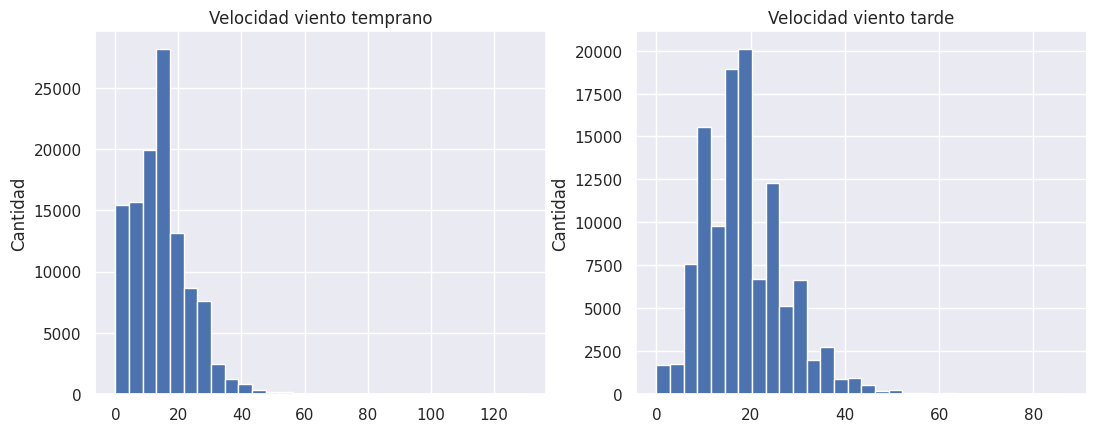

In [150]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)


dataset.velocidad_viendo_temprano.plot(kind= 'hist', ax= axes[0], bins=30)
axes[0].set_title("Velocidad viento temprano")
axes[0].set_ylabel("Cantidad")

dataset.velocidad_viendo_tarde.plot(kind= 'hist', ax= axes[1], bins=30)
axes[1].set_title("Velocidad viento tarde")
axes[1].set_ylabel("Cantidad")

plt.show()

Aparentemente, el promedio velocidad del viento ronda los 20 km/h, ahora analizaremos cada una especificamente si al otro dia llovieron hamburguesas o no.

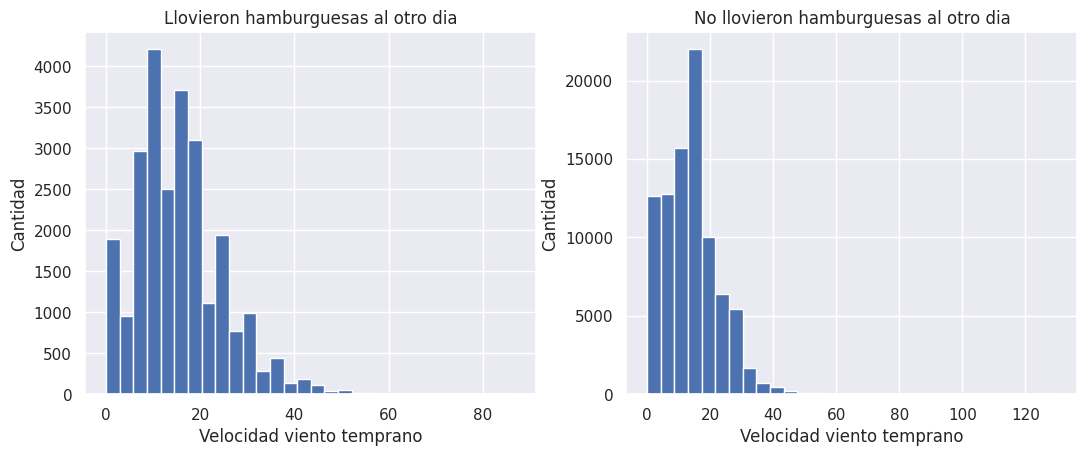

In [151]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)


dataset_llovio.velocidad_viendo_temprano.plot(kind= 'hist', ax= axes[0], bins=30)
axes[0].set_title("Llovieron hamburguesas al otro dia")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Velocidad viento temprano")

dataset_no_llovio.velocidad_viendo_temprano.plot(kind= 'hist', ax= axes[1], bins=30)
axes[1].set_title("No llovieron hamburguesas al otro dia")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Velocidad viento temprano")

plt.show()

Podemos observar que las distribuciones son bastante parecidas, con aparentes outliers en el caso de no lluvia. Nada que nos permita aproximar mejor nuestra predicción hasta el momento.

Ahora veamos la velocidad del viento tarde.

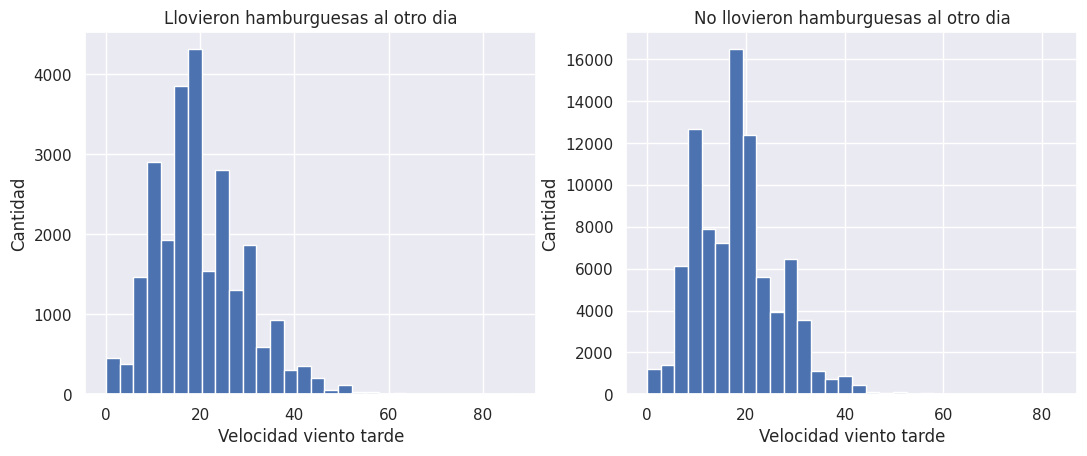

In [152]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)


dataset_llovio.velocidad_viendo_tarde.plot(kind= 'hist', ax= axes[0], bins=30)
axes[0].set_title("Llovieron hamburguesas al otro dia")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Velocidad viento tarde")

dataset_no_llovio.velocidad_viendo_tarde.plot(kind= 'hist', ax= axes[1], bins=30)
axes[1].set_title("No llovieron hamburguesas al otro dia")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Velocidad viento tarde")

plt.show()

Los resultados son bastantes similares a los anteriores, por lo que las conclusiones son las mismas.

### Ráfagas de viento

Empezamos visualizando la distribución de las direcciones en las rafagas de viento más fuertes detectadas en cada día, según si llovieron hamburguesas al otro día o no.



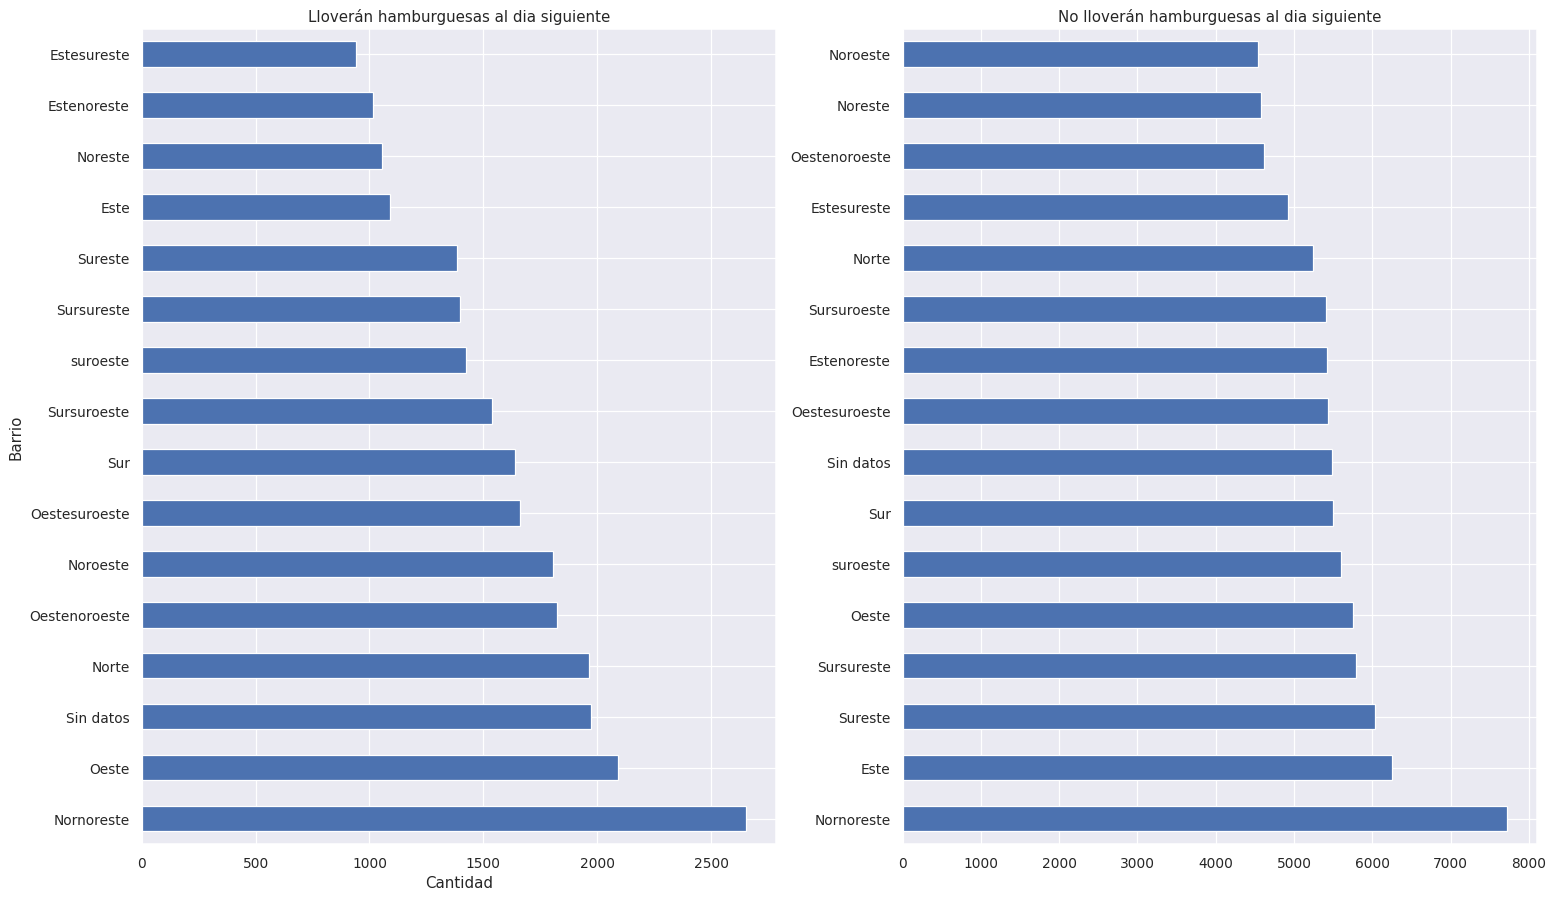

In [153]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10 * 2, 12], dpi=90)

dataset_llovio.rafaga_viento_max_direccion.value_counts().plot(kind= 'barh', ax= axes[0])
axes[0].set_title("Lloverán hamburguesas al dia siguiente")
axes[0].set_ylabel("Barrio")
axes[0].set_xlabel("Cantidad")

dataset_no_llovio.rafaga_viento_max_direccion.value_counts().plot(kind= 'barh', ax= axes[1])
axes[1].set_title("No lloverán hamburguesas al dia siguiente")

plt.show()

Lo que notamos es una distribución muy parecida en ambos casos, lo cual parece determinar que este atributo es independiente de si lloverán o no. Del primer histograma se podría pensar que con rafagas de ciertas zonas es mas probable que lluevan hamburguesas que si provienen de otras, pero esto no nos ayuda a formalizar una mejor predicción.

Ahora analizaremos la velocidad de las rafagas.

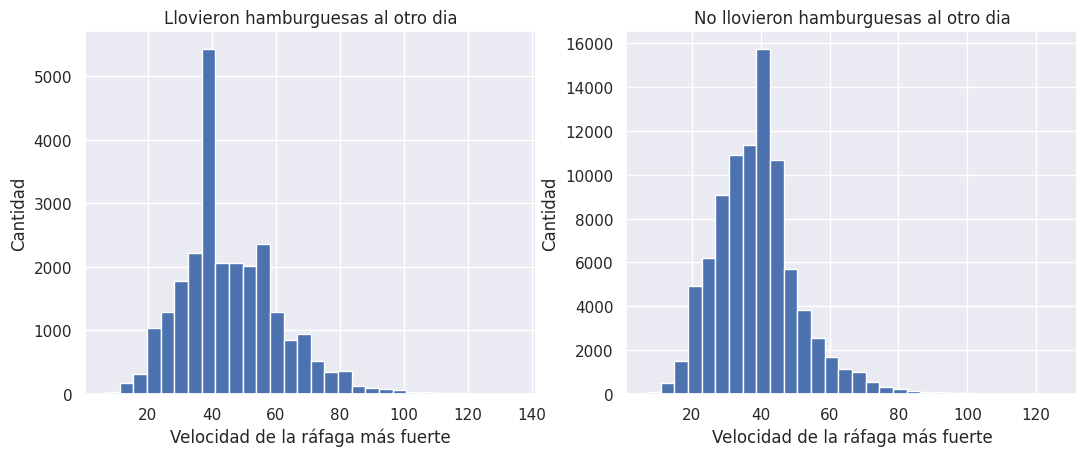

In [154]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)


dataset_llovio.rafaga_viento_max_velocidad.plot(kind= 'hist', ax= axes[0], bins=30)
axes[0].set_title("Llovieron hamburguesas al otro dia")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Velocidad de la ráfaga más fuerte")

dataset_no_llovio.rafaga_viento_max_velocidad.plot(kind= 'hist', ax= axes[1], bins=30)
axes[1].set_title("No llovieron hamburguesas al otro dia")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Velocidad de la ráfaga más fuerte")

plt.show()

Aquí podemos notar distribuciones muy parecidas con poca información relevante. Lo único que parecería resaltar es que los dias que llovieron hamburguesas, se detectaron casos donde la ráfaga de viento alcanzó una velocidad mayor a 95, mientras que en los que no llovió, si lo hizo parecieran menos casos. Por ello intentamos mejorar la predicción, pero esta solo mejora en una magnitud del 0,0004.

In [155]:
pred = pd.Series(np.zeros(len(dataset))).replace({1: "si", 0: "no"})
pred[(dataset.humedad_tarde >= 79)| (dataset.rafaga_viento_max_velocidad > 95)] = 'si'
accuracy_score(dataset.llovieron_hamburguesas_al_dia_siguiente, pred)

0.8238630368259998

### Horas de sol

Ahora veremos la relación que tienen las horas de sol. Para empezar, visualizaremos comparando en los dos casos, como lo venimos haciendo.

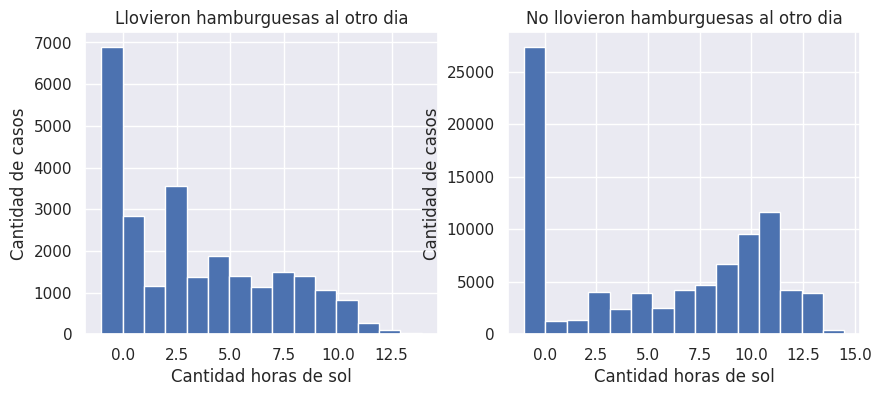

In [156]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 4], dpi=100)


dataset_llovio.horas_de_sol.plot(kind= 'hist', ax= axes[0], bins=15)
axes[0].set_title("Llovieron hamburguesas al otro dia")
axes[0].set_ylabel("Cantidad de casos")
axes[0].set_xlabel("Cantidad horas de sol")

dataset_no_llovio.horas_de_sol.plot(kind= 'hist', ax= axes[1], bins=15)
axes[1].set_title("No llovieron hamburguesas al otro dia")
axes[1].set_ylabel("Cantidad de casos")
axes[1].set_xlabel("Cantidad horas de sol")

plt.show()

Lo que observamos en el grafico es que a medida que aumenta la cantidad de horas en un dia, es menor la cantidad de dias en los que al siguiente llovieron hamburguesas. Estando presentes muchos dias de esta clase donde hubo cero horas de sol. A pesar de esto, no podemos mejorar la predicción, ya que también hubo muchos dias en los que hubo cero horas de sol y al dia siguiente no llovieron hamburguesas. Si vamos a las cantidades, de los dias que no hubo sol en el dataset, 2000 si llovieron al otro dia, y solo 1000 no llovieron. A la hora de tener en cuenta esto en la predicción vemos como esto la empeora, por lo que lo descartaremos.

In [157]:
pred = pd.Series(np.zeros(len(dataset))).replace({1: "si", 0: "no"})
pred[(dataset.humedad_tarde >= 79)| (dataset.rafaga_viento_max_velocidad > 95) | (dataset.horas_de_sol == 0)] = 'si'
accuracy_score(dataset.llovieron_hamburguesas_al_dia_siguiente, pred)

0.822966128521684

### Agua evaporada

Ahora analizaremos si hay una diferencia con respecto al agua evaporada.

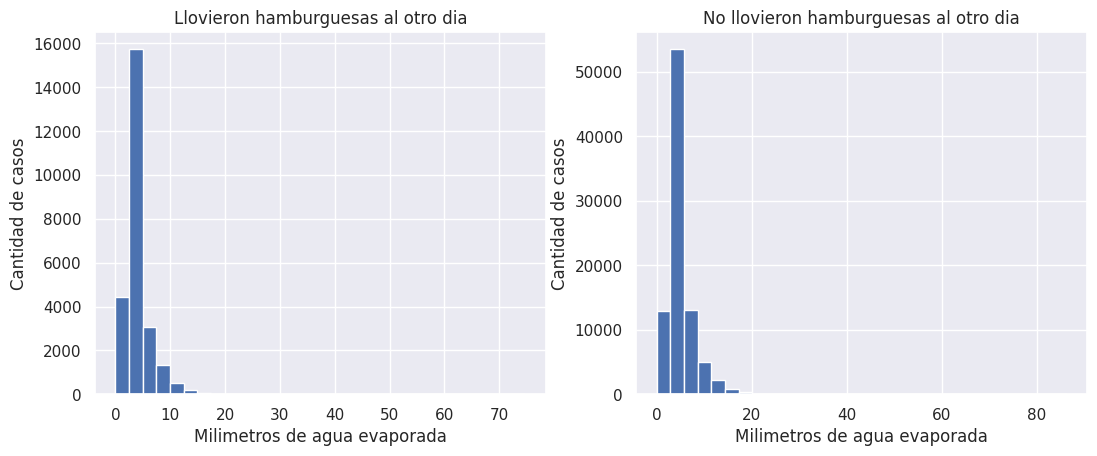

In [158]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)


dataset_llovio.mm_evaporados_agua.plot(kind= 'hist', ax= axes[0], bins=30)
axes[0].set_title("Llovieron hamburguesas al otro dia")
axes[0].set_ylabel("Cantidad de casos")
axes[0].set_xlabel("Milimetros de agua evaporada")

dataset_no_llovio.mm_evaporados_agua.plot(kind= 'hist', ax= axes[1], bins=30)
axes[1].set_title("No llovieron hamburguesas al otro dia")
axes[1].set_ylabel("Cantidad de casos")
axes[1].set_xlabel("Milimetros de agua evaporada")

plt.show()

A simple vista las distribuciones son muy similares así que descartamos que podamos sacarle alguna utilidad.

### Lluvia

Analizaremos si la lluvia tiene una relación con el target que intentamos predecir. Veremos la cantidad de lluvia según si el dia es target o no.

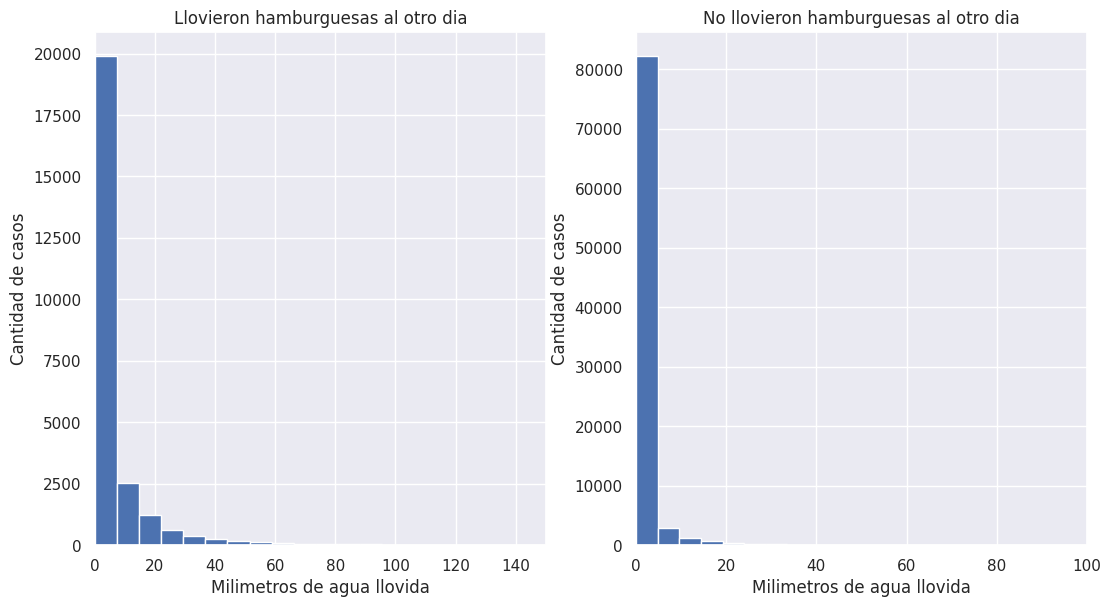

In [159]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 6.8], dpi=100)


dataset_llovio.mm_lluvia_dia.plot(kind= 'hist', ax= axes[0], bins=50, xlim=(0,150))
axes[0].set_title("Llovieron hamburguesas al otro dia")
axes[0].set_ylabel("Cantidad de casos")
axes[0].set_xlabel("Milimetros de agua llovida")

dataset_no_llovio.mm_lluvia_dia.plot(kind= 'hist', ax= axes[1], bins=50, xlim=(0,100))
axes[1].set_title("No llovieron hamburguesas al otro dia")
axes[1].set_ylabel("Cantidad de casos")
axes[1].set_xlabel("Milimetros de agua llovida")

plt.show()

Acá podemos encontrar una pequeña diferencia, lo que nos indica que cuando llueven hamburguesas al otro dia, ese dia presenta una cantidad de milimetros de agua que es poco usual cuando no lloverán hamburguesas. Esa linea está delimitada por los 36 milimetros, lo cual mejora muy levemente la predicción.

In [160]:
pred = pd.Series(np.zeros(len(dataset))).replace({1: "si", 0: "no"})
pred[(dataset.humedad_tarde >= 79) | (dataset.rafaga_viento_max_velocidad > 95) | (dataset.mm_lluvia_dia > 36)] = 'si'
accuracy_score(dataset.llovieron_hamburguesas_al_dia_siguiente, pred)

0.8244521824768738

### Dirección del viento

Empezaremos analizando la distribución segun si el dia es nuestro target o no, viendo la dirección temprana del viento.

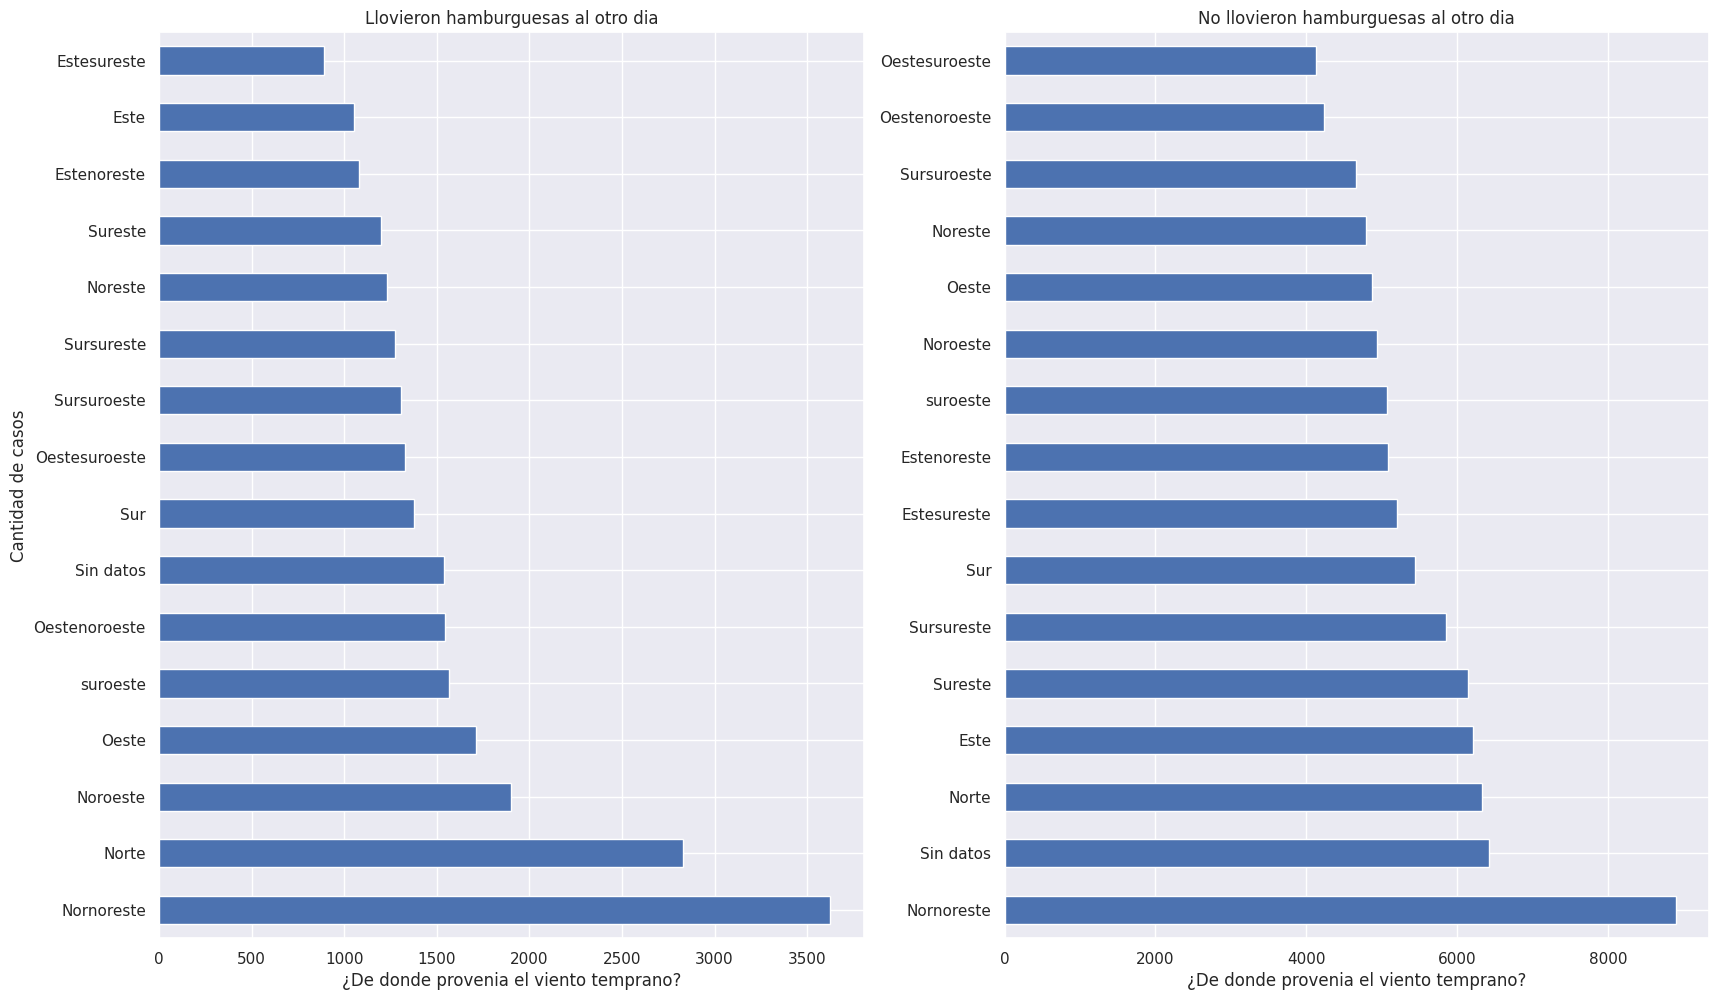

In [161]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10 * 2, 12], dpi=100)


dataset_llovio.direccion_viento_temprano.value_counts().plot(kind= 'barh', ax= axes[0])
axes[0].set_title("Llovieron hamburguesas al otro dia")
axes[0].set_ylabel("Cantidad de casos")
axes[0].set_xlabel("¿De donde provenia el viento temprano?")

dataset_no_llovio.direccion_viento_temprano.value_counts().plot(kind= 'barh', ax= axes[1])
axes[1].set_title("No llovieron hamburguesas al otro dia")
axes[1].set_xlabel("¿De donde provenia el viento temprano?")

plt.show()

No hay mucho que podamos extraer de estos gráficos. Tal vez ahora sabemos que es mas probable encontrar un dia target con el viento temprano proveniendo del nornoeste que, por ejemplo, del estesureste, pero también es verdad para los dias no target. Por lo tanto no podemos mejorar la predicción de manera determinista.

Veamos si con la dirección tarde se presenta alguna diferencia.

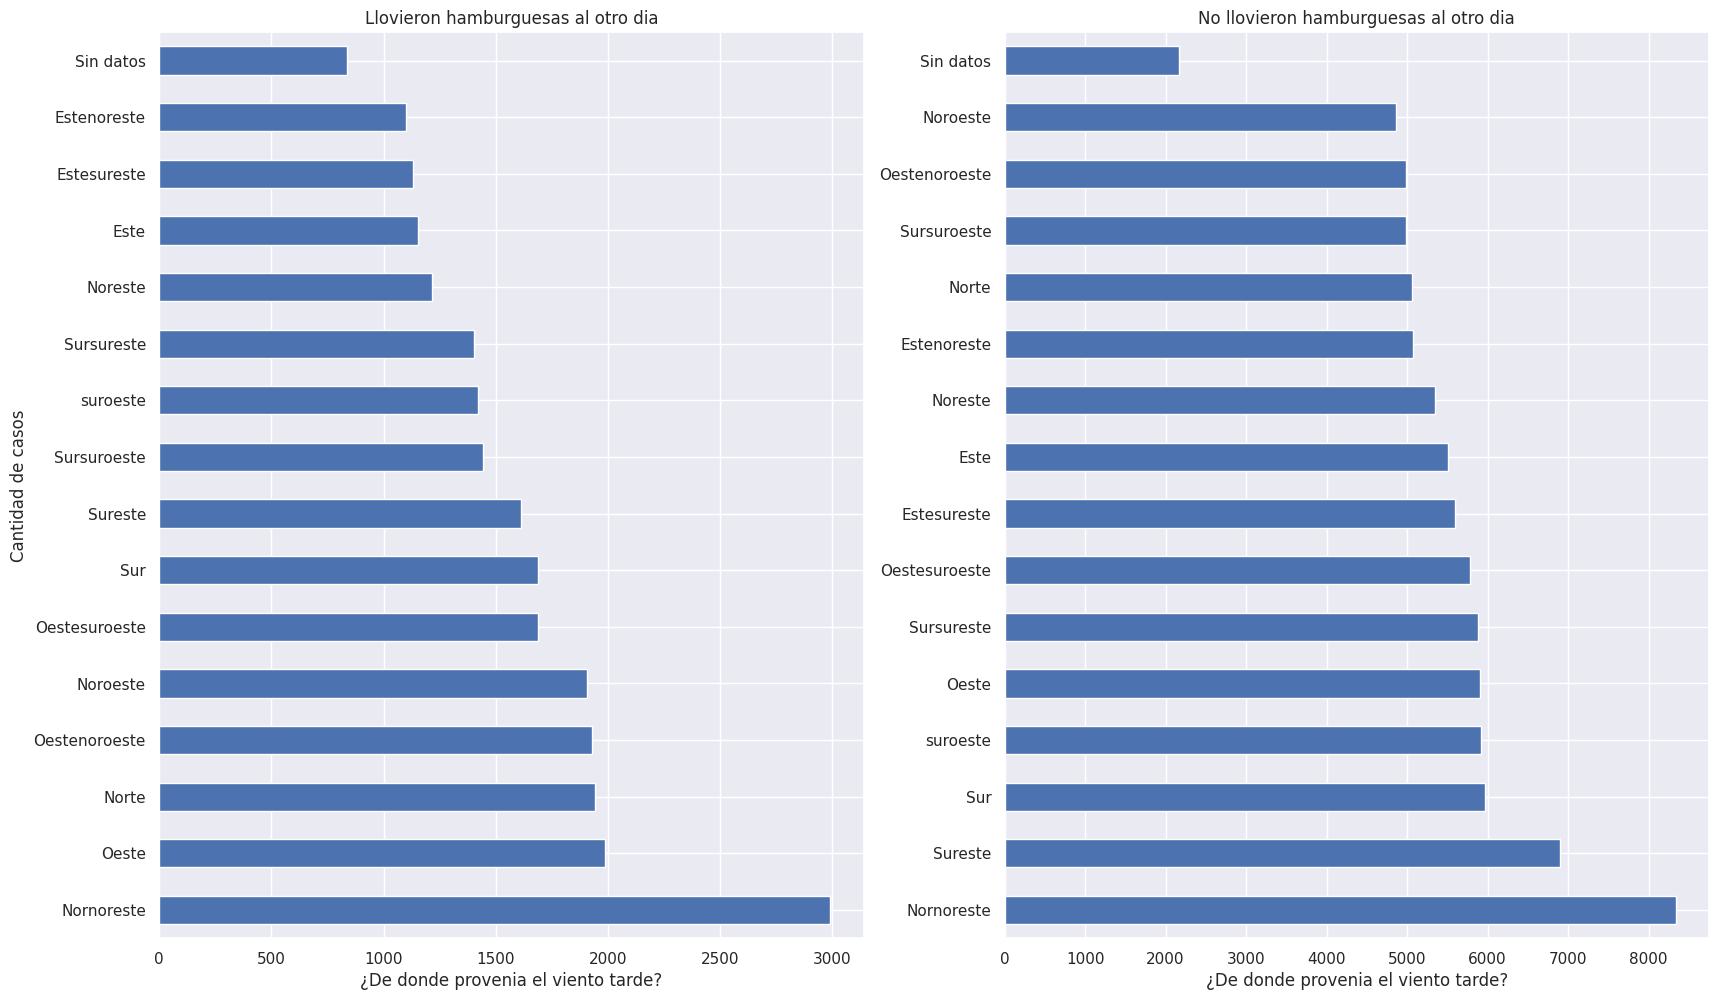

In [162]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10 * 2, 12], dpi=100)


dataset_llovio.direccion_viento_tarde.value_counts().plot(kind= 'barh', ax= axes[0])
axes[0].set_title("Llovieron hamburguesas al otro dia")
axes[0].set_ylabel("Cantidad de casos")
axes[0].set_xlabel("¿De donde provenia el viento tarde?")

dataset_no_llovio.direccion_viento_tarde.value_counts().plot(kind= 'barh', ax= axes[1])
axes[1].set_title("No llovieron hamburguesas al otro dia")
axes[1].set_xlabel("¿De donde provenia el viento tarde?")

plt.show()

Bastante parecido a lo anterior, nada deterministico que extraer para mejorar la predicción.

### Presión atmosferica

Veamos si la presión atmosferica temprano tiene relevancia con respecto al target buscado. Para ello, como venimos haciendo, separemos en dos y grafiquemos.

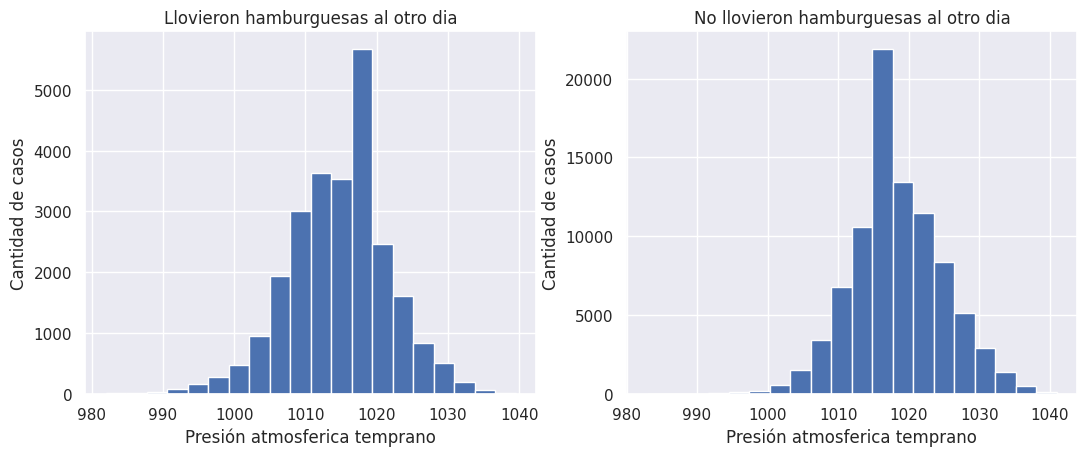

In [163]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)


dataset_llovio.presion_atmosferica_temprano.plot(kind= 'hist', ax= axes[0], bins=20)
axes[0].set_title("Llovieron hamburguesas al otro dia")
axes[0].set_ylabel("Cantidad de casos")
axes[0].set_xlabel("Presión atmosferica temprano")

dataset_no_llovio.presion_atmosferica_temprano.plot(kind= 'hist', ax= axes[1], bins=20)
axes[1].set_title("No llovieron hamburguesas al otro dia")
axes[1].set_ylabel("Cantidad de casos")
axes[1].set_xlabel("Presión atmosferica temprano")

plt.show()

Notamos como detalle que los dias target pueden tener dias con una presión temprana menor o igual a 994 mientras que en los dias no target esto al menos en proporcion es menos común, salvo algunos outliers visibles (notables por que la escala empieza en 980).

Sin embargo, la predicción aumenta muy insignificativamente, por lo que lo descartaremos para dejar nuestro método de predicción lo mas simple posible.

In [164]:
pred = pd.Series(np.zeros(len(dataset))).replace({1: "si", 0: "no"})
pred[(dataset.humedad_tarde >= 79) | (dataset.rafaga_viento_max_velocidad > 95) | (dataset.mm_lluvia_dia > 36) | (dataset.presion_atmosferica_temprano <= 994)] = 'si'
accuracy_score(dataset.llovieron_hamburguesas_al_dia_siguiente, pred)

0.8248654637543527

Ahora veamos que ocurre con la presión atmosferica tarde.

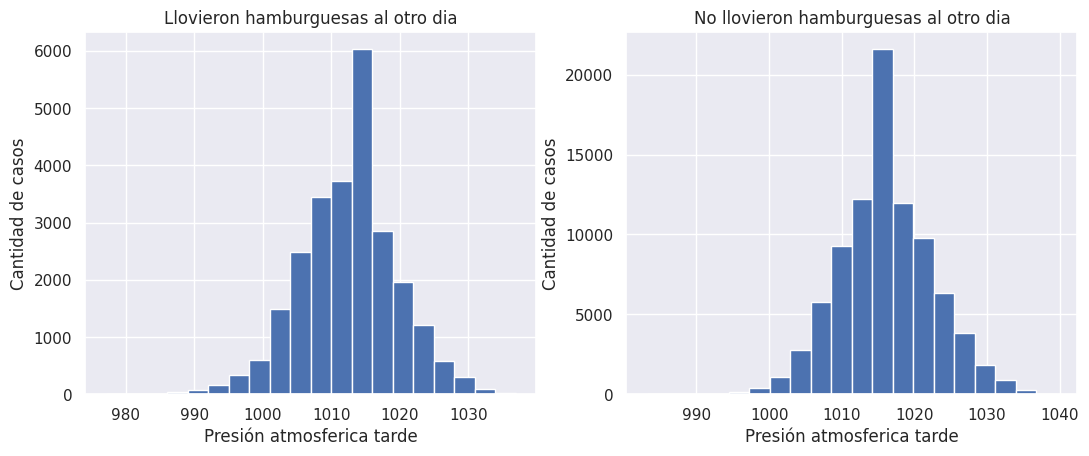

In [165]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)


dataset_llovio.presion_atmosferica_tarde.plot(kind= 'hist', ax= axes[0], bins=20)
axes[0].set_title("Llovieron hamburguesas al otro dia")
axes[0].set_ylabel("Cantidad de casos")
axes[0].set_xlabel("Presión atmosferica tarde")

dataset_no_llovio.presion_atmosferica_tarde.plot(kind= 'hist', ax= axes[1], bins=20)
axes[1].set_title("No llovieron hamburguesas al otro dia")
axes[1].set_ylabel("Cantidad de casos")
axes[1].set_xlabel("Presión atmosferica tarde")

plt.show()

En este caso observamos que para presiones menores a 995 disminuye significativamente la cantidad de dias que no target(que son los mas abundantes) mientras que los dias si target se presentan casos representativos. Por ello intentamos mejorar la predicción con este dato, y obtenemos una certeza del 82,5%.

In [166]:
pred = pd.Series(np.zeros(len(dataset))).replace({1: "si", 0: "no"})
pred[(dataset.humedad_tarde >= 79) | (dataset.rafaga_viento_max_velocidad > 95) | (dataset.mm_lluvia_dia > 36) | (dataset.presion_atmosferica_tarde <= 995)] = 'si'
accuracy_score(dataset.llovieron_hamburguesas_al_dia_siguiente, pred)

0.8253139179065105

## ¿Existe alguna relación entre la Humedad y la Presión atmosférica según hayan o no llovido hamburguesas al día siguiente?

Nos resulta interesante analizar estas dos features en simultaneo dado a que la lluvia de hamburguesas parece comportarse como la lluvia, y en ésta última, la presión y la humedad suelen tener características particulares. El analisis lo vamos a hacer tomando la humedad tarde y presión atmosférica tarde debido a que son los valores más 'actualizados' o cercanos al día siguiente, en el que queremos predecir si lloverá o no hamburguesas.   
Comenzamos ploteando y observando qué distribución aparece

In [78]:
def funcion_recta(x):
    return -(1/21)*x**2 + (293/3)*x - (349920/7)

recta_x = np.linspace(980,1040,num=100)
recta_y = funcion_recta(recta_x)

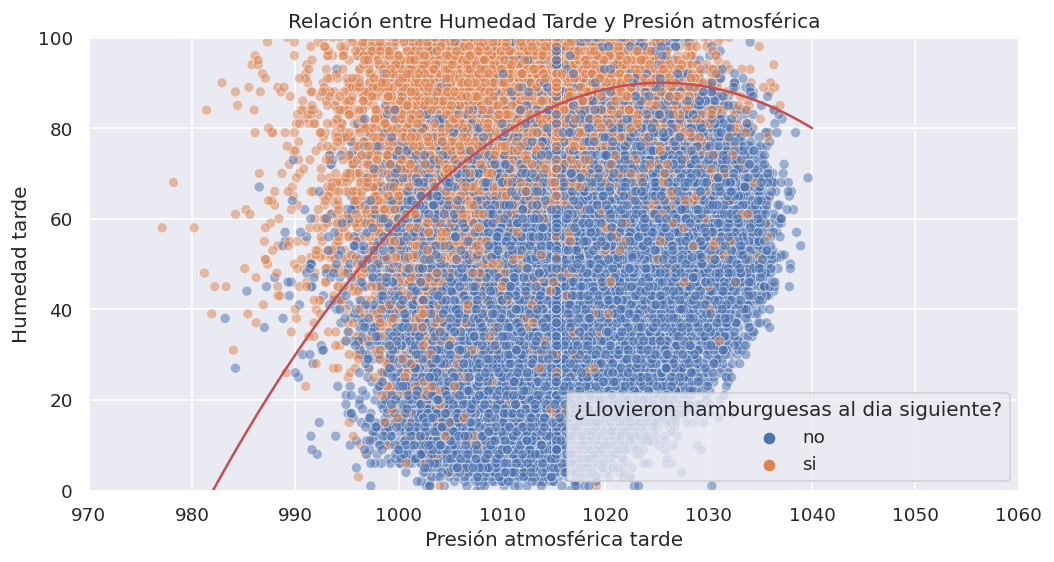

In [79]:
plt.figure(figsize=(10,5),dpi=120)

sns.scatterplot(
    x='presion_atmosferica_tarde',
    y='humedad_tarde',
    hue=dataset['llovieron_hamburguesas_al_dia_siguiente'].tolist(),
    data=dataset,
    alpha=0.5,
)

plt.plot(recta_x,recta_y, color='r')

plt.legend(title="¿Llovieron hamburguesas al dia siguiente?")
plt.ylabel("Humedad tarde")
plt.xlabel("Presión atmosférica tarde")
plt.ylim(0,100)
plt.xticks(np.arange(970,1070,10))
plt.title('Relación entre Humedad Tarde y Presión atmosférica')
plt.show()

Aparentemente vemos que si una instancia posee pares de humedad tarde y presión atmosférica tarde para los valores de esta esquina superior izquierda (humedad alta y presión baja) es bastante probable que lluevan hamburguesas al día siguiente. Podriamos trazar una recta/polinomio (como se ve en el gráfico), sin embargo a pesar de haber definido cada punto en el gráfico con una transparencia del 50%, ésto no nos permite ver la densidad de puntos naranjas que hay realmente allí, sólo sabemos que casi no hay azules.  
Para observar con más claridad esto, procedemos a dividir en categorías (muy baja, baja, media, alta, muy alta) nuestras dos variables continuas, y así poder armar un mapa de calor.

In [80]:
#Asigna a cada instancia una categoría de acuerdo a que valor posee en esa feature: Muy bajo, bajo, medio, alto, muy alto
def escala_de_valores(serie):
    delta = (serie.max() - serie.min()) / 5
    
    valor_muy_bajo = (serie >= serie.min()) & (serie < (serie.min()+delta))
    valor_bajo     = (serie >= (serie.min()+delta)) & (serie < (serie.min()+2*delta))
    valor_medio    = (serie >= (serie.min()+2*delta)) & (serie < (serie.min()+3*delta))
    valor_alto     = (serie >= (serie.min()+3*delta)) & (serie < (serie.min()+4*delta))
    valor_muy_alto = (serie >= (serie.min()+4*delta)) & (serie <= (serie.min()+5*delta))
    
    return [valor_muy_bajo, valor_bajo, valor_medio, valor_alto, valor_muy_alto]

#Añade la nueva columna a un DataFrame
def creacion_columna_escala_de_valores(dataset_usado, lista_con_escala_de_valores, nombre_feature):
    dataset_usado.loc[lista_con_escala_de_valores[0], nombre_feature] = 'muy baja'
    dataset_usado.loc[lista_con_escala_de_valores[1], nombre_feature] = 'baja'
    dataset_usado.loc[lista_con_escala_de_valores[2], nombre_feature] = 'media'
    dataset_usado.loc[lista_con_escala_de_valores[3], nombre_feature] = 'alta'
    dataset_usado.loc[lista_con_escala_de_valores[4], nombre_feature] = 'muy alta'

In [81]:
escala_de_valores_humedad_tarde   = escala_de_valores(dataset.humedad_tarde)
escala_de_valores_presion_at      = escala_de_valores(dataset.presion_atmosferica_tarde)
df_humedad_presion = pd.DataFrame(index=dataset.index)
df_humedad_presion['llovieron_hamburguesas_al_dia_siguiente'] = dataset['llovieron_hamburguesas_al_dia_siguiente']

creacion_columna_escala_de_valores(df_humedad_presion, escala_de_valores_humedad_tarde, 'nivel_humedad_tarde')
creacion_columna_escala_de_valores(df_humedad_presion, escala_de_valores_presion_at, 'nivel_presion_atmosferica_tarde')

df_humedad_presion = df_humedad_presion.groupby(['nivel_humedad_tarde','nivel_presion_atmosferica_tarde']).agg({'llovieron_hamburguesas_al_dia_siguiente':porcentaje_lluvia})

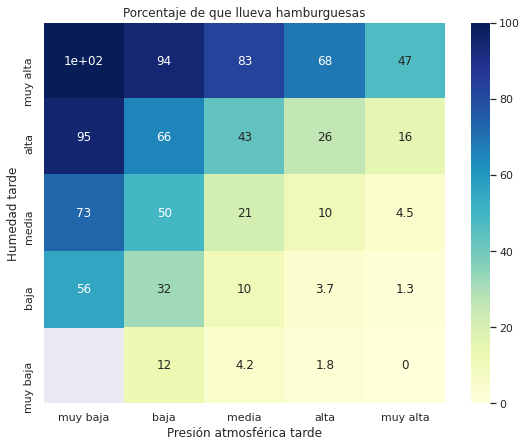

In [82]:
tab_humedad_presion = pd.pivot_table(data = df_humedad_presion, 
                                     index = 'nivel_humedad_tarde', 
                                     values = 'llovieron_hamburguesas_al_dia_siguiente', 
                                     columns = 'nivel_presion_atmosferica_tarde')
tab_humedad_presion = tab_humedad_presion.reindex( ['muy baja' ,'baja', 'media', 'alta', 'muy alta'],axis = 1)
tab_humedad_presion = tab_humedad_presion.reindex( ['muy alta' ,'alta', 'media', 'baja', 'muy baja'],axis = 0)

heatmap_humedad_presion = sns.heatmap(tab_humedad_presion, cmap="YlGnBu", annot=True)
heatmap_humedad_presion.set_ylabel("Humedad tarde")
heatmap_humedad_presion.set_xlabel("Presión atmosférica tarde")
heatmap_humedad_presion.set_title("Porcentaje de que llueva hamburguesas")

plt.show()

Mirando el mapa de calor podemos concluir que efectivamente, las muestras  en las cuales llovió hamburguesas al día siguiente se concentran en mayor medida en la mitad superior izquierda con valores altos de humedad y valores bajos de presión atmosférica.  
Esta información también la usaremos en el baseline. Diremos que lloverán hamburguesas al día siguiente cuando:  
    
* Humedad >= Media    y  Presion = Muy baja  
* Humedad >= Alta     y  Presion <= Baja
* Humedad = Muy alta  y  Presion <= Media

También usaremos del primer Scatter Plot el hecho de que para la presión atmosférica menor a 990 casi todos los puntos son naranjas, es decir, para un gran porcentaje de las instancias que cumplen esto, llueven hamburguesas al día siguiente

## Conclusiones

Habiendo analizado todos estos datos, podemos sacar las siguientes conclusiones:

* Se puede lograr una mayor certeza si se dice siempre que no lloverá al dia siguiente, a que si se tira una moneda.
* El factor mas relevante a la hora de determinar si lloverán hamburguesas o no es la humedad a la tarde.
* Otros factores con poca relevancia son la velocidad máxima que presentó una rafaga de viento ese dia, los milimetros de lluvia, la presión atmosférica por la tarde y la nubosidad.
* Llueve en todas las estaciones por igual, y en todos los barrios.
* La presión atmosferica temprano se relaciona linealmente con la tarde, notando cantidades altas. Esto probablemente se deba a que no varía tan rapido, mantendiendose durante el dia.
* La temperatura minima se relaciona linealmente con la temperatura temprano, y la máxima se relaciona linealmente con la tarde, acompañando a la intuición, ya que es temprano cuando el sol no ha estado presente por un largo tiempo, y tarde cuando el sol está en su momento de mayor actividad.
* La relación entre la nubosidad y las horas de sol es directa, acompañando a la intuición.
* Los dias con mucha o poca nubosidad, tienden a permanecer con la misma nubosidad a lo largo del día.
* Existe una relación entre la humedad tarde y la presión atmosférica tarde respecto de si lloverán hamburguesas al dia siguiente tal que ésto último es más probable para dias con alta humedad tarde y presión atmosférica baja.

## Baseline

Luego de realizar el analisis de cada una de las distintas features llegamos a la conclusión de que las mas determinantes a la hora de predecir si mañana lloverá hamburguesas o no al dia siguiente son:
* La humedad por la tarde
* La velocidad maxima de la rafaga de viento
* Los milimetros de lluvia que hubo ese dia
* Presión atmosferica por la tarde
* En algunos casos la nubosidad por la tarde puede resultar útil
  
A partir del analisis anterior se obtienen los valores utilizados para armar el baseline. Para poder ejecutar el baseline sobre un dataset, es condición primero aplicarle la función de feature engineering para hacer los tratamientos necesarios sobre el dataset. Por lo tanto el baseline quedaría:

In [83]:
from typing import List
def baseline(X: pd.DataFrame) -> List[str]:
    
    cond_relacion_presion_humedad = ( (X.presion_atmosferica_tarde < 990 ) |
                                     ((X.humedad_tarde >= 55) & (X.presion_atmosferica_tarde < 1005)) |
                                     ((X.humedad_tarde >= 74) & (X.presion_atmosferica_tarde < 1012)) |
                                     ((X.humedad_tarde >= 84) & (X.presion_atmosferica_tarde < 1020)) )
    
    prediccion = pd.Series(np.zeros(len(X))).replace({1: "si", 0: "no"})
    
    prediccion[(X.humedad_tarde >= 79)                 | 
               (X.rafaga_viento_max_velocidad > 95)    | 
               (X.mm_lluvia_dia >= 50 )                |
               (X.presion_atmosferica_tarde <= 994)    |
               cond_relacion_presion_humedad     
              ]= 'si'
    
    return prediccion.to_list()

A continuación se encuentran concentradas en una única función todas las decisiones tomadas durante el preprocesado de los datos:

In [84]:
def feature_engineering(ds):
    ds = ds[(ds.llovieron_hamburguesas_al_dia_siguiente == 'si') | (ds.llovieron_hamburguesas_al_dia_siguiente == 'no')]
    ds = ds[ds.presion_atmosferica_tarde != '10.167.769.999.999.900']
    ds = ds[ds.presion_atmosferica_tarde != '1.009.555']
    ds.presion_atmosferica_tarde = ds.presion_atmosferica_tarde.astype(np.float64)
    ds.horas_de_sol.fillna(value=-1, inplace=True)
    ds.nubosidad_temprano.fillna(value=-1, inplace=True)
    ds.nubosidad_tarde.fillna(value=-1, inplace=True)
    #Eliminamos filas con nubosidad 9
    ds = ds[(ds.nubosidad_temprano != 9)&(ds.nubosidad_tarde != 9)]

    #Obtenemos horas de sol a partir de niveles de nubosidad

    for i in np.sort(ds.nubosidad_tarde.unique())[1:]:
        nubosidad_i = (ds.nubosidad_tarde == i)
        promedio_hs_de_sol = ds[ (ds.horas_de_sol != -1) & nubosidad_i].horas_de_sol.mean()
        ds.loc[(ds.horas_de_sol == -1) & nubosidad_i, 'horas_de_sol'] = promedio_hs_de_sol

    for i in np.sort(ds.nubosidad_temprano.unique())[1:]:
        nubosidad_i = (ds.nubosidad_temprano == i)
        promedio_hs_de_sol = ds[ (ds.horas_de_sol != -1) & nubosidad_i].horas_de_sol.mean()
        ds.loc[(ds.horas_de_sol == -1) & nubosidad_i, 'horas_de_sol'] = promedio_hs_de_sol
        

    for i in [0,1,7,8]:
        promedio_nubosidad_tarde = round(dataset[(dataset.nubosidad_temprano == i) & (dataset.nubosidad_tarde != -1)].nubosidad_tarde.mean())
        promedio_nubosidad_temprano = round(dataset[(dataset.nubosidad_tarde == i) & (dataset.nubosidad_temprano != -1)].nubosidad_temprano.mean())
        dataset.loc[(dataset.nubosidad_temprano == i) & (dataset.nubosidad_tarde == -1),'nubosidad_tarde'] = promedio_nubosidad_tarde
        dataset.loc[(dataset.nubosidad_tarde == i) & (dataset.nubosidad_temprano == -1),'nubosidad_temprano'] = promedio_nubosidad_temprano
    
    imputer = KNNImputer(missing_values=-1,n_neighbors=1)
    imputer_values = imputer.fit_transform(dataset[['horas_de_sol','nubosidad_tarde', 'nubosidad_temprano']])
    dataset['horas_de_sol'] = imputer_values[:,0].round(1)
    dataset[['nubosidad_tarde', 'nubosidad_temprano']] = imputer_values[:,1:].round(0)
    
    hs_sol_segun_nub= []

    #Promedio de hs de sol para c/u de las nubosidades
    for i in [0,1,2,3,4,5,6,7,8]:
        hs_sol_segun_nub.append(ds[ds.nubosidad_tarde == i].horas_de_sol.mean())

    #De acuerdo a las hs de sol, comparamos con el promedio de las nubosidades. Si el valor es mayor o igual le asignamos dicha nubosidad.
    for j in [0,1,2,3,4,5,6,7,8]:
        ds.loc[(ds.horas_de_sol >= hs_sol_segun_nub[j]) & (ds.nubosidad_tarde == -1),'nubosidad_tarde'] = j
        ds.loc[(ds.horas_de_sol >= hs_sol_segun_nub[j]) & (ds.nubosidad_temprano == -1),'nubosidad_temprano'] = j

    #Los mas chicos los asignamos a nubosidad 8
    ds.loc[(ds.horas_de_sol != -1) & (ds.nubosidad_tarde == -1),'nubosidad_tarde'] = 8
    ds.loc[(ds.horas_de_sol != -1) & (ds.nubosidad_temprano == -1),'nubosidad_temprano'] = 8
    
    #Completamos missing values en features numéricas
    ds['humedad_temprano'].fillna(value=ds['humedad_temprano'].mean(), inplace=True)
    ds['humedad_tarde'].fillna(value=ds['humedad_tarde'].mean(), inplace=True)
    ds['presion_atmosferica_temprano'].fillna(value=ds['presion_atmosferica_temprano'].mean(), inplace=True)
    ds['presion_atmosferica_tarde'].fillna(value=ds['presion_atmosferica_tarde'].mean(), inplace=True)
    ds['rafaga_viento_max_velocidad'].fillna(value=ds['rafaga_viento_max_velocidad'].mean(), inplace=True)
    ds['velocidad_viendo_temprano'].fillna(value=ds['velocidad_viendo_temprano'].mean(), inplace=True)
    ds['velocidad_viendo_tarde'].fillna(value=ds['velocidad_viendo_tarde'].mean(), inplace=True)
    ds['temperatura_temprano'].fillna(value=ds['temperatura_temprano'].mean(), inplace=True)
    ds['temperatura_tarde'].fillna(value=ds['temperatura_tarde'].mean(), inplace=True)
    ds['temp_min'].fillna(value=ds['temp_min'].mean(), inplace=True)
    ds['temp_max'].fillna(value=ds['temp_max'].mean(), inplace=True)
    ds['mm_lluvia_dia'].fillna(value=0, inplace=True)
    ds['mm_evaporados_agua'].fillna(value=ds['mm_evaporados_agua'].median(), inplace=True)
    

    #Completamos missing values en features categóricas
    columnas_categoricas_con_nan = ds.columns[(ds.dtypes == 'object') & (ds.isnull().any()) ]
    for col in columnas_categoricas_con_nan:
        ds[col].fillna(value='Sin datos', inplace=True)
        
    ds.reset_index(inplace=True)
    return ds

Creamos un nuevo Dataframe con el set de datos en cuestión, hacemos el preprocesamiento y realizamos la predicción:

In [85]:
nuevo_dataset = pd.read_csv('Datasets/features.csv')
nuevo_target = pd.read_csv('Datasets/target.csv')
nuevo_dataset = pd.merge(nuevo_dataset, nuevo_target, how='left', left_on='id', right_on='id')
nuevo_dataset = feature_engineering(nuevo_dataset)
prediccion = baseline(nuevo_dataset)

/home/nacho/Escritorio/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [86]:
accuracy_score(nuevo_dataset.llovieron_hamburguesas_al_dia_siguiente, prediccion)

0.8286641342196898